In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
from collections import Counter
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import sn
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from scipy import stats
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
drive.mount('/content/gdrive')

TIME_STEPS = 200
STEP = 40
from tensorflow.keras.models import load_model
from scipy.io import loadmat

Mounted at /content/gdrive


In [ ]:
"""register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)"""

"register_matplotlib_converters()\nsns.set(style='whitegrid', palette='muted', font_scale=1.5)\nrcParams['figure.figsize'] = 22, 10\nRANDOM_SEED = 42\nnp.random.seed(RANDOM_SEED)\ntf.random.set_seed(RANDOM_SEED)"

<b><h1> Pre-Processing dei dati </h1></b> <br>


In [ ]:
def create_dataset(X, y, time_steps=1, step=1):
  TIME_STEPS = 200
  STEP = 40
  Xs, ys = [], []
  for i in range(0, len(X) - time_steps, step):
    v = X.iloc[i: (i+time_steps)].values
    labels = y.iloc[i: i+time_steps]
    Xs.append(v)
    ys.append(stats.mode(labels)[0][0])
  return np.array(Xs), np.array(ys).reshape(-1, 1)

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Validation Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
column_names = ['user_id', 'activity', 'timestamp', 'X', 'Y', 'Z']
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dataset/DatasetUniba.csv', header = None, names = column_names)
df.dropna(axis=0, how='any', inplace=True)
df

,user_id,activity,timestamp,X,Y,Z
0,1,BackwardFall,0,-2.120995,-7.684790,-0.116293
1,1,BackwardFall,5,-1.837475,-7.524046,-0.273713
2,1,BackwardFall,10,-1.528029,-7.397976,-0.263592
3,1,BackwardFall,15,-1.099379,-7.245015,-0.243442
4,1,BackwardFall,20,-0.651752,-7.112909,-0.147084
...,...,...,...,...,...,...
970347,19,Walking,15030,3.607614,3.775315,-1.813403
970348,19,Walking,15035,3.749106,4.399148,-2.120795
970349,19,Walking,15040,3.862242,5.141159,-2.582244
970350,19,Walking,15045,3.913796,6.209425,-3.008182


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
df["activity"].loc[df.activity == 'BackwardFall'] = "Fall"
df["activity"].loc[df.activity == 'ForwardFall'] = "Fall"
df["activity"].loc[df.activity == 'LeftFall'] = "Fall"
df["activity"].loc[df.activity == 'RightFall'] = "Fall"
#df = df[df.activity != "Sitting"] #Rimuovendo il commento iniziale si eseguirà il classificatore no sitting
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970352 entries, 0 to 970351
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    970352 non-null  int64  
 1   activity   970352 non-null  object 
 2   timestamp  970352 non-null  int64  
 3   X          970352 non-null  float64
 4   Y          970352 non-null  float64
 5   Z          970352 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 44.4+ MB


In [ ]:
df.describe()

,user_id,timestamp,X,Y,Z
count,970352.000000,970352.000000,970352.000000,970352.000000,970352.000000
mean,9.652475,7486.316867,0.406984,-0.656867,-0.275370
std,5.530966,4343.144385,4.259469,7.203429,4.695829
min,1.000000,0.000000,-56.221443,-61.331863,-58.738260
25%,5.000000,3730.000000,-2.204359,-3.413708,-3.185539
50%,9.000000,7460.000000,0.432485,-0.275161,-0.170318
75%,14.000000,11220.000000,2.824348,1.845646,1.931052
max,19.000000,15115.000000,57.871265,61.735350,52.757180


In [ ]:
print(df["user_id"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


<b><h1> LOO CNN</h1></b> <br>
Definizione del classificatore Convolutional Neural Network e stampa delle metriche della classificazione.

In [ ]:
from sklearn.metrics import *

In [ ]:
k = len(df["user_id"].unique())
indici = np.arange(start=1, stop=k+1)
print(indici)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [ ]:
df1 = pd.DataFrame()
principal = indici
f1 = []
acc = []

for i in principal:
  df1 = pd.DataFrame()
  indici = np.delete(indici, np.where(indici == i))

  for k in indici:
    df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)

  print("UTENTE: %d" % i)

  df_train = df1
  df_test = df[df['user_id'] == int(i)]

  scale_columns = ['X', 'Y', 'Z']
  scaler = RobustScaler()
  scaler = scaler.fit(df[scale_columns])

  df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
  df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

  X_train, y_train = create_dataset(df_train[['X', 'Y', 'Z']], df_train.activity, TIME_STEPS, STEP)
  X_test, y_test = create_dataset(df_test[['X', 'Y', 'Z']], df_test.activity, TIME_STEPS, STEP)

  enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
  enc = enc.fit(y_train)

  y_train = enc.transform(y_train)
  y_test = enc.transform(y_test)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

  """Conv2D"""
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = X_train[0].shape))
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
  model.add(Dropout(0.5))
  """"""

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy', f1_m])

  model.fit(X_train, y_train, batch_size = 512, epochs = 10, validation_split = 0.2, verbose=1)

  #print(model.evaluate(X_train,y_train))
  #print(model.evaluate(X_test,y_test))

  #plot_learningCurve(history, 6)

  rounded_labels=np.argmax(y_test, axis=1)
  y_pred = np.argmax(model.predict(X_test), axis=-1)

  acc.append(accuracy_score(rounded_labels, y_pred))
  f1.append(f1_score(rounded_labels, y_pred, average='macro'))

  print(classification_report(rounded_labels, y_pred, digits=4))

  indici = principal


print(np.mean(acc))  #calcola la media di tutte le accuratezze
print(np.mean(f1))

#plot_learningCurve(history, 6)
rounded_labels=np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

#plt.figure(figsize=(15,15))
array = confusion_matrix(rounded_labels,y_pred);
df_cm = pd.DataFrame(array, range(5),range(5));
df_cm.columns = ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]
df_cm.index = df_cm.columns = ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]

sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 15},yticklabels=(["Fall", "Hopping", "Jogging", "Sitting", "Walking"]))# font size
plt.show();

#Bi-LSTM


<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)


UTENTE: 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.Data

Epoch 1/20
45/45 [==============================] - 20s 69ms/step - loss: 1.0330 - accuracy: 0.5806 - f1_m: 0.4820 - precision_m: 0.7947 - recall_m: 0.3626
Epoch 2/20
45/45 [==============================] - 3s 67ms/step - loss: 0.7572 - accuracy: 0.6884 - f1_m: 0.6684 - precision_m: 0.8086 - recall_m: 0.5702
Epoch 3/20
45/45 [==============================] - 3s 69ms/step - loss: 0.5815 - accuracy: 0.7932 - f1_m: 0.7747 - precision_m: 0.8416 - recall_m: 0.7187
Epoch 4/20
45/45 [==============================] - 3s 67ms/step - loss: 0.6433 - accuracy: 0.7472 - f1_m: 0.7372 - precision_m: 0.8395 - recall_m: 0.6587
Epoch 5/20
45/45 [==============================] - 3s 67ms/step - loss: 0.4660 - accuracy: 0.8323 - f1_m: 0.8203 - precision_m: 0.8652 - recall_m: 0.7800
Epoch 6/20
45/45 [==============================] - 3s 67ms/step - loss: 0.4128 - accuracy: 0.8488 - f1_m: 0.8407 - precision_m: 0.8727 - recall_m: 0.8110
Epoch 7/20
45/45 [==============================] - 3s 69ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
45/45 [==============================] - 12s 71ms/step - loss: 1.0691 - accuracy: 0.5651 - f1_m: 0.4601 - precision_m: 0.7904 - recall_m: 0.3414
Epoch 2/20
45/45 [==============================] - 3s 70ms/step - loss: 0.6437 - accuracy: 0.7464 - f1_m: 0.7194 - precision_m: 0.8513 - recall_m: 0.6252
Epoch 3/20
45/45 [==============================] - 3s 70ms/step - loss: 0.4725 - accuracy: 0.8321 - f1_m: 0.8225 - precision_m: 0.8764 - recall_m: 0.7752
Epoch 4/20
45/45 [==============================] - 3s 69ms/step - loss: 0.5341 - accuracy: 0.7936 - f1_m: 0.7847 - precision_m: 0.8716 - recall_m: 0.7138
Epoch 5/20
45/45 [==============================] - 3s 70ms/step - loss: 0.4118 - accuracy: 0.8509 - f1_m: 0.8421 - precision_m: 0.8929 - recall_m: 0.7972
Epoch 6/20
45/45 [==============================] - 3s 71ms/step - loss: 0.4025 - accuracy: 0.8526 - f1_m: 0.8480 - precision_m: 0.8871 - recall_m: 0.8125
Epoch 7/20
45/45 [==============================] - 3s 72ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
45/45 [==============================] - 12s 72ms/step - loss: 1.0985 - accuracy: 0.5536 - f1_m: 0.4346 - precision_m: 0.7763 - recall_m: 0.3235
Epoch 2/20
45/45 [==============================] - 3s 69ms/step - loss: 0.6413 - accuracy: 0.7418 - f1_m: 0.7164 - precision_m: 0.8360 - recall_m: 0.6298
Epoch 3/20
45/45 [==============================] - 3s 69ms/step - loss: 0.5334 - accuracy: 0.7966 - f1_m: 0.7838 - precision_m: 0.8430 - recall_m: 0.7330
Epoch 4/20
45/45 [==============================] - 3s 69ms/step - loss: 0.5313 - accuracy: 0.7993 - f1_m: 0.7909 - precision_m: 0.8593 - recall_m: 0.7335
Epoch 5/20
45/45 [==============================] - 3s 70ms/step - loss: 0.4229 - accuracy: 0.8483 - f1_m: 0.8409 - precision_m: 0.8906 - recall_m: 0.7967
Epoch 6/20
45/45 [==============================] - 3s 70ms/step - loss: 0.3597 - accuracy: 0.8816 - f1_m: 0.8758 - precision_m: 0.9056 - recall_m: 0.8479
Epoch 7/20
45/45 [==============================] - 3s 70ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


45/45 [==============================] - 13s 71ms/step - loss: 1.1927 - accuracy: 0.5162 - f1_m: 0.3468 - precision_m: 0.6434 - recall_m: 0.2537
Epoch 2/20
45/45 [==============================] - 3s 69ms/step - loss: 0.6527 - accuracy: 0.7402 - f1_m: 0.7274 - precision_m: 0.8418 - recall_m: 0.6426
Epoch 3/20
45/45 [==============================] - 3s 69ms/step - loss: 0.5271 - accuracy: 0.7949 - f1_m: 0.7852 - precision_m: 0.8656 - recall_m: 0.7188
Epoch 4/20
45/45 [==============================] - 3s 70ms/step - loss: 0.4828 - accuracy: 0.8171 - f1_m: 0.8084 - precision_m: 0.8606 - recall_m: 0.7625
Epoch 5/20
45/45 [==============================] - 3s 71ms/step - loss: 0.4630 - accuracy: 0.8163 - f1_m: 0.8065 - precision_m: 0.8773 - recall_m: 0.7467
Epoch 6/20
45/45 [==============================] - 3s 70ms/step - loss: 0.3573 - accuracy: 0.8680 - f1_m: 0.8657 - precision_m: 0.9004 - recall_m: 0.8338
Epoch 7/20
45/45 [==============================] - 3s 71ms/step - loss: 0.3361 

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)


UTENTE: 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.Data

Epoch 1/20


<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

44/44 [==============================] - 13s 72ms/step - loss: 1.0833 - accuracy: 0.5667 - f1_m: 0.4460 - precision_m: 0.7445 - recall_m: 0.3315
Epoch 2/20
44/44 [==============================] - 3s 69ms/step - loss: 0.6737 - accuracy: 0.7275 - f1_m: 0.6962 - precision_m: 0.8383 - recall_m: 0.5986
Epoch 3/20
44/44 [==============================] - 3s 70ms/step - loss: 0.5012 - accuracy: 0.8161 - f1_m: 0.8036 - precision_m: 0.8520 - recall_m: 0.7606
Epoch 4/20
44/44 [==============================] - 3s 70ms/step - loss: 0.4032 - accuracy: 0.8590 - f1_m: 0.8531 - precision_m: 0.8893 - recall_m: 0.8199
Epoch 5/20
44/44 [==============================] - 3s 70ms/step - loss: 0.3558 - accuracy: 0.8739 - f1_m: 0.8710 - precision_m: 0.8975 - recall_m: 0.8460
Epoch 6/20
44/44 [==============================] - 3s 70ms/step - loss: 0.3557 - accuracy: 0.8801 - f1_m: 0.8764 - precision_m: 0.8994 - recall_m: 0.8546
Epoch 7/20
44/44 [==============================] - 3s 71ms/step - loss: 0.3707 

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
46/46 [==============================] - 12s 71ms/step - loss: 1.0750 - accuracy: 0.5640 - f1_m: 0.4497 - precision_m: 0.8054 - recall_m: 0.3306
Epoch 2/20
46/46 [==============================] - 3s 70ms/step - loss: 0.7452 - accuracy: 0.6944 - f1_m: 0.6593 - precision_m: 0.8294 - recall_m: 0.5503
Epoch 3/20
46/46 [==============================] - 3s 69ms/step - loss: 0.5809 - accuracy: 0.7739 - f1_m: 0.7596 - precision_m: 0.8449 - recall_m: 0.6907
Epoch 4/20
46/46 [==============================] - 3s 69ms/step - loss: 0.5446 - accuracy: 0.7935 - f1_m: 0.7714 - precision_m: 0.8283 - recall_m: 0.7220
Epoch 5/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5388 - accuracy: 0.7957 - f1_m: 0.7874 - precision_m: 0.8491 - recall_m: 0.7347
Epoch 6/20
46/46 [==============================] - 3s 71ms/step - loss: 0.4347 - accuracy: 0.8429 - f1_m: 0.8294 - precision_m: 0.8803 - recall_m: 0.7843
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20


<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

46/46 [==============================] - 13s 71ms/step - loss: 1.0686 - accuracy: 0.5704 - f1_m: 0.4661 - precision_m: 0.7983 - recall_m: 0.3460
Epoch 2/20
46/46 [==============================] - 3s 68ms/step - loss: 0.7172 - accuracy: 0.7164 - f1_m: 0.6802 - precision_m: 0.8543 - recall_m: 0.5685
Epoch 3/20
46/46 [==============================] - 3s 68ms/step - loss: 0.6099 - accuracy: 0.7577 - f1_m: 0.7482 - precision_m: 0.8351 - recall_m: 0.6783
Epoch 4/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4829 - accuracy: 0.8172 - f1_m: 0.8044 - precision_m: 0.8671 - recall_m: 0.7508
Epoch 5/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4381 - accuracy: 0.8431 - f1_m: 0.8382 - precision_m: 0.8814 - recall_m: 0.7993
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.3769 - accuracy: 0.8660 - f1_m: 0.8613 - precision_m: 0.8916 - recall_m: 0.8330
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4365 

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20


<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

46/46 [==============================] - 13s 69ms/step - loss: 1.0592 - accuracy: 0.5666 - f1_m: 0.4638 - precision_m: 0.7881 - recall_m: 0.3461
Epoch 2/20
46/46 [==============================] - 3s 69ms/step - loss: 0.6354 - accuracy: 0.7477 - f1_m: 0.7235 - precision_m: 0.8331 - recall_m: 0.6407
Epoch 3/20
46/46 [==============================] - 3s 71ms/step - loss: 0.4863 - accuracy: 0.8165 - f1_m: 0.8019 - precision_m: 0.8591 - recall_m: 0.7522
Epoch 4/20
46/46 [==============================] - 3s 69ms/step - loss: 0.5013 - accuracy: 0.8223 - f1_m: 0.8100 - precision_m: 0.8609 - recall_m: 0.7649
Epoch 5/20
46/46 [==============================] - 3s 71ms/step - loss: 0.4043 - accuracy: 0.8556 - f1_m: 0.8488 - precision_m: 0.8911 - recall_m: 0.8106
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4185 - accuracy: 0.8553 - f1_m: 0.8509 - precision_m: 0.8852 - recall_m: 0.8194
Epoch 7/20
46/46 [==============================] - 3s 71ms/step - loss: 0.3778 

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
46/46 [==============================] - 12s 72ms/step - loss: 1.0834 - accuracy: 0.5491 - f1_m: 0.4382 - precision_m: 0.7777 - recall_m: 0.3205
Epoch 2/20
46/46 [==============================] - 3s 69ms/step - loss: 0.6562 - accuracy: 0.7388 - f1_m: 0.7197 - precision_m: 0.8490 - recall_m: 0.6277
Epoch 3/20
46/46 [==============================] - 3s 68ms/step - loss: 0.4965 - accuracy: 0.8063 - f1_m: 0.7973 - precision_m: 0.8663 - recall_m: 0.7393
Epoch 4/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4578 - accuracy: 0.8317 - f1_m: 0.8210 - precision_m: 0.8599 - recall_m: 0.7856
Epoch 5/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4323 - accuracy: 0.8399 - f1_m: 0.8320 - precision_m: 0.8713 - recall_m: 0.7963
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4239 - accuracy: 0.8430 - f1_m: 0.8346 - precision_m: 0.8742 - recall_m: 0.7989
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)


UTENTE: 10


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.Data

Epoch 1/20
46/46 [==============================] - 13s 70ms/step - loss: 1.0520 - accuracy: 0.5685 - f1_m: 0.4893 - precision_m: 0.8254 - recall_m: 0.3636
Epoch 2/20
46/46 [==============================] - 3s 68ms/step - loss: 0.6945 - accuracy: 0.7131 - f1_m: 0.6725 - precision_m: 0.8453 - recall_m: 0.5619
Epoch 3/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5554 - accuracy: 0.7780 - f1_m: 0.7546 - precision_m: 0.8272 - recall_m: 0.6943
Epoch 4/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5343 - accuracy: 0.7880 - f1_m: 0.7809 - precision_m: 0.8571 - recall_m: 0.7179
Epoch 5/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4682 - accuracy: 0.8256 - f1_m: 0.8106 - precision_m: 0.8711 - recall_m: 0.7584
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.3826 - accuracy: 0.8653 - f1_m: 0.8584 - precision_m: 0.8918 - recall_m: 0.8281
Epoch 7/20
46/46 [==============================] - 3s 69ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)


UTENTE: 11


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.Data

Epoch 1/20
46/46 [==============================] - 12s 71ms/step - loss: 1.0779 - accuracy: 0.5617 - f1_m: 0.4479 - precision_m: 0.7980 - recall_m: 0.3350
Epoch 2/20
46/46 [==============================] - 3s 68ms/step - loss: 0.6099 - accuracy: 0.7601 - f1_m: 0.7367 - precision_m: 0.8379 - recall_m: 0.6595
Epoch 3/20
46/46 [==============================] - 3s 69ms/step - loss: 0.5242 - accuracy: 0.7912 - f1_m: 0.7739 - precision_m: 0.8319 - recall_m: 0.7241
Epoch 4/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4697 - accuracy: 0.8139 - f1_m: 0.8019 - precision_m: 0.8582 - recall_m: 0.7529
Epoch 5/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4186 - accuracy: 0.8408 - f1_m: 0.8363 - precision_m: 0.8841 - recall_m: 0.7937
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.5115 - accuracy: 0.8098 - f1_m: 0.8036 - precision_m: 0.8430 - recall_m: 0.7681
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
46/46 [==============================] - 12s 70ms/step - loss: 1.0930 - accuracy: 0.5493 - f1_m: 0.4411 - precision_m: 0.7374 - recall_m: 0.3276
Epoch 2/20
46/46 [==============================] - 3s 69ms/step - loss: 0.7320 - accuracy: 0.7001 - f1_m: 0.6555 - precision_m: 0.8476 - recall_m: 0.5373
Epoch 3/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5502 - accuracy: 0.7876 - f1_m: 0.7716 - precision_m: 0.8446 - recall_m: 0.7123
Epoch 4/20
46/46 [==============================] - 3s 68ms/step - loss: 0.4507 - accuracy: 0.8356 - f1_m: 0.8252 - precision_m: 0.8694 - recall_m: 0.7857
Epoch 5/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4258 - accuracy: 0.8461 - f1_m: 0.8411 - precision_m: 0.8748 - recall_m: 0.8099
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.3782 - accuracy: 0.8674 - f1_m: 0.8670 - precision_m: 0.8924 - recall_m: 0.8432
Epoch 7/20
46/46 [==============================] - 3s 71ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


46/46 [==============================] - 13s 70ms/step - loss: 1.0545 - accuracy: 0.5867 - f1_m: 0.4843 - precision_m: 0.8092 - recall_m: 0.3626
Epoch 2/20
46/46 [==============================] - 3s 70ms/step - loss: 0.6229 - accuracy: 0.7566 - f1_m: 0.7367 - precision_m: 0.8423 - recall_m: 0.6560
Epoch 3/20
46/46 [==============================] - 3s 69ms/step - loss: 0.5455 - accuracy: 0.8023 - f1_m: 0.7886 - precision_m: 0.8522 - recall_m: 0.7343
Epoch 4/20
46/46 [==============================] - 3s 68ms/step - loss: 0.5021 - accuracy: 0.8128 - f1_m: 0.8038 - precision_m: 0.8477 - recall_m: 0.7645
Epoch 5/20
46/46 [==============================] - 3s 68ms/step - loss: 0.4099 - accuracy: 0.8507 - f1_m: 0.8477 - precision_m: 0.8838 - recall_m: 0.8146
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4199 - accuracy: 0.8424 - f1_m: 0.8447 - precision_m: 0.8796 - recall_m: 0.8128
Epoch 7/20
46/46 [==============================] - 3s 72ms/step - loss: 0.4435 

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
46/46 [==============================] - 13s 69ms/step - loss: 1.0478 - accuracy: 0.5665 - f1_m: 0.4629 - precision_m: 0.8258 - recall_m: 0.3407
Epoch 2/20
46/46 [==============================] - 3s 68ms/step - loss: 0.6707 - accuracy: 0.7216 - f1_m: 0.6816 - precision_m: 0.8168 - recall_m: 0.5898
Epoch 3/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5110 - accuracy: 0.8102 - f1_m: 0.7962 - precision_m: 0.8535 - recall_m: 0.7464
Epoch 4/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4336 - accuracy: 0.8504 - f1_m: 0.8455 - precision_m: 0.8789 - recall_m: 0.8148
Epoch 5/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4077 - accuracy: 0.8513 - f1_m: 0.8462 - precision_m: 0.8814 - recall_m: 0.8140
Epoch 6/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4110 - accuracy: 0.8499 - f1_m: 0.8461 - precision_m: 0.8932 - recall_m: 0.8041
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
46/46 [==============================] - 11s 71ms/step - loss: 1.1085 - accuracy: 0.5552 - f1_m: 0.4220 - precision_m: 0.7011 - recall_m: 0.3157
Epoch 2/20
46/46 [==============================] - 3s 68ms/step - loss: 0.6392 - accuracy: 0.7403 - f1_m: 0.7194 - precision_m: 0.8306 - recall_m: 0.6354
Epoch 3/20
46/46 [==============================] - 3s 68ms/step - loss: 0.5275 - accuracy: 0.7940 - f1_m: 0.7838 - precision_m: 0.8484 - recall_m: 0.7289
Epoch 4/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4325 - accuracy: 0.8368 - f1_m: 0.8373 - precision_m: 0.8870 - recall_m: 0.7931
Epoch 5/20
46/46 [==============================] - 3s 70ms/step - loss: 0.3691 - accuracy: 0.8678 - f1_m: 0.8654 - precision_m: 0.8985 - recall_m: 0.8348
Epoch 6/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4350 - accuracy: 0.8366 - f1_m: 0.8356 - precision_m: 0.8642 - recall_m: 0.8090
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)


UTENTE: 16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.Data

Epoch 1/20


<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

46/46 [==============================] - 13s 70ms/step - loss: 1.0607 - accuracy: 0.5635 - f1_m: 0.4777 - precision_m: 0.8197 - recall_m: 0.3513
Epoch 2/20
46/46 [==============================] - 3s 69ms/step - loss: 0.8238 - accuracy: 0.6641 - f1_m: 0.6297 - precision_m: 0.8391 - recall_m: 0.5052
Epoch 3/20
46/46 [==============================] - 3s 70ms/step - loss: 0.6756 - accuracy: 0.7327 - f1_m: 0.6935 - precision_m: 0.8698 - recall_m: 0.5828
Epoch 4/20
46/46 [==============================] - 3s 71ms/step - loss: 0.4888 - accuracy: 0.8192 - f1_m: 0.8045 - precision_m: 0.8613 - recall_m: 0.7555
Epoch 5/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5577 - accuracy: 0.7849 - f1_m: 0.7692 - precision_m: 0.8333 - recall_m: 0.7145
Epoch 6/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4808 - accuracy: 0.8101 - f1_m: 0.8055 - precision_m: 0.8564 - recall_m: 0.7607
Epoch 7/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4191 

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
46/46 [==============================] - 12s 72ms/step - loss: 1.0739 - accuracy: 0.5720 - f1_m: 0.4505 - precision_m: 0.7782 - recall_m: 0.3369
Epoch 2/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5851 - accuracy: 0.7812 - f1_m: 0.7580 - precision_m: 0.8542 - recall_m: 0.6835
Epoch 3/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4412 - accuracy: 0.8323 - f1_m: 0.8220 - precision_m: 0.8652 - recall_m: 0.7831
Epoch 4/20
46/46 [==============================] - 3s 68ms/step - loss: 0.4279 - accuracy: 0.8467 - f1_m: 0.8410 - precision_m: 0.8743 - recall_m: 0.8103
Epoch 5/20
46/46 [==============================] - 3s 69ms/step - loss: 0.3453 - accuracy: 0.8801 - f1_m: 0.8748 - precision_m: 0.9075 - recall_m: 0.8449
Epoch 6/20
46/46 [==============================] - 3s 71ms/step - loss: 0.3994 - accuracy: 0.8602 - f1_m: 0.8568 - precision_m: 0.8823 - recall_m: 0.8328
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - lo

<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Epoch 1/20
46/46 [==============================] - 12s 71ms/step - loss: 1.0802 - accuracy: 0.5644 - f1_m: 0.4316 - precision_m: 0.7183 - recall_m: 0.3328
Epoch 2/20
46/46 [==============================] - 3s 70ms/step - loss: 0.6131 - accuracy: 0.7438 - f1_m: 0.7327 - precision_m: 0.8243 - recall_m: 0.6610
Epoch 3/20
46/46 [==============================] - 3s 69ms/step - loss: 0.5567 - accuracy: 0.7731 - f1_m: 0.7577 - precision_m: 0.8219 - recall_m: 0.7031
Epoch 4/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4604 - accuracy: 0.8165 - f1_m: 0.8093 - precision_m: 0.8512 - recall_m: 0.7715
Epoch 5/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4067 - accuracy: 0.8462 - f1_m: 0.8389 - precision_m: 0.8742 - recall_m: 0.8065
Epoch 6/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4101 - accuracy: 0.8468 - f1_m: 0.8430 - precision_m: 0.8769 - recall_m: 0.8119
Epoch 7/20
46/46 [==============================] - 3s 69ms/step - lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-f0ea85021349>:11: FutureWarning: The frame.appe

UTENTE: 19


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-3-1519449969f6>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-3-1519449969f6>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.Data

Epoch 1/20
46/46 [==============================] - 13s 70ms/step - loss: 1.0102 - accuracy: 0.5844 - f1_m: 0.4887 - precision_m: 0.7591 - recall_m: 0.3818
Epoch 2/20
46/46 [==============================] - 3s 68ms/step - loss: 0.6324 - accuracy: 0.7331 - f1_m: 0.7140 - precision_m: 0.8162 - recall_m: 0.6356
Epoch 3/20
46/46 [==============================] - 3s 69ms/step - loss: 0.4813 - accuracy: 0.8125 - f1_m: 0.8026 - precision_m: 0.8533 - recall_m: 0.7578
Epoch 4/20
46/46 [==============================] - 3s 71ms/step - loss: 0.4578 - accuracy: 0.8292 - f1_m: 0.8229 - precision_m: 0.8744 - recall_m: 0.7773
Epoch 5/20
46/46 [==============================] - 3s 70ms/step - loss: 0.5658 - accuracy: 0.7871 - f1_m: 0.7790 - precision_m: 0.8602 - recall_m: 0.7137
Epoch 6/20
46/46 [==============================] - 3s 70ms/step - loss: 0.4911 - accuracy: 0.8260 - f1_m: 0.8141 - precision_m: 0.8754 - recall_m: 0.7613
Epoch 7/20
46/46 [==============================] - 3s 70ms/step - lo

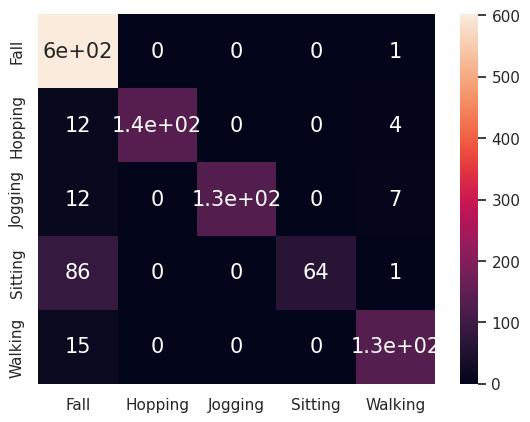

In [ ]:
df1 = pd.DataFrame()
principal = indici
f1 = []
acc = []

for i in principal:
  df1 = pd.DataFrame()
  indici = np.delete(indici, np.where(indici == i))

  for k in indici:
    df1 = df1.append(df[df['user_id'] == int(k)], ignore_index=True)

  print("UTENTE: %d" % i)

  df_train = df1
  df_test = df[df['user_id'] == int(i)]

  scale_columns = ['X', 'Y', 'Z']
  scaler = RobustScaler()
  scaler = scaler.fit(df[scale_columns])

  df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
  df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

  X_train, y_train = create_dataset(df_train[['X', 'Y', 'Z']], df_train.activity, TIME_STEPS, STEP)
  X_test, y_test = create_dataset(df_test[['X', 'Y', 'Z']], df_test.activity, TIME_STEPS, STEP)

  enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
  enc = enc.fit(y_train)

  y_train = enc.transform(y_train)
  y_test = enc.transform(y_test)

  #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

  model = keras.Sequential()
  model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]])))
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64)))
  model.add(keras.layers.Dropout(rate=0.2))

  model.add(keras.layers.Dense(units=64, activation='relu'))
  model.add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

  model.fit(X_train, y_train, batch_size = 512, epochs = 20, verbose=1)
  #print(model.evaluate(X_train,y_train))
  #print(model.evaluate(X_test,y_test))

  #plot_learningCurve(history, 6)

  rounded_labels=np.argmax(y_test, axis=1)
  y_pred = np.argmax(model.predict(X_test), axis=-1)

  acc.append(accuracy_score(rounded_labels, y_pred))
  f1.append(f1_score(rounded_labels, y_pred, average='macro'))

  print(classification_report(rounded_labels, y_pred, digits=4))

  indici = principal

print(np.mean(acc))
print(np.mean(f1))

#plot_learningCurve(history, 6)
rounded_labels=np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

#plt.figure(figsize=(15,15))
array = confusion_matrix(rounded_labels,y_pred);
df_cm = pd.DataFrame(array, range(5),range(5));
df_cm.columns = ["Sitting", "Jogging", "Fall", "Hopping", "Walking"]
df_cm.index = df_cm.columns = ["Sitting", "Jogging", "Fall", "Hopping", "Walking"]

sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 15},yticklabels=(["Sitting", "Jogging", "Fall", "Hopping", "Walking"]))# font size
plt.show();

In [ ]:
model.save('/content/gdrive/MyDrive/Bi_LSTM.h5')

In [ ]:
model = load_model('/content/gdrive/MyDrive/Bi_LSTM.h5' , custom_objects={"f1_m": f1_m, "precision_m" : precision_m, "recall_m" : recall_m})

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_36 (Bidirecti  (None, 200, 128)         34816     
 onal)                                                           
                                                                 
 dropout_54 (Dropout)        (None, 200, 128)          0         
                                                                 
 bidirectional_37 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dropout_55 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dropout_56 (Dropout)        (None, 64)              

In [ ]:
def create_dataset2(X, time_steps=1, step=1):
  TIME_STEPS = 200
  STEP = 40
  Xs = []
  for i in range(0, len(X)-time_steps, step):
    v = X.iloc[i: (i+time_steps)].values
    Xs.append(v)
  return np.array(Xs)

funzione a cui passo nome file csv di un utente e che da in pasto i dati dei sensori al modello per ottenere le predizioni per ogni riga

In [ ]:
def predict(file_name):
  csv = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file_name, index_col=None).drop(columns=['Unnamed: 0'])

  scaler.fit(csv[scale_columns])#X,Y,Z
  csv.loc[:, scale_columns] = scaler.transform(csv[scale_columns].to_numpy())

  X_train_m = create_dataset2(csv[['X', 'Y', 'Z']], TIME_STEPS, 1)

  predictions = model.predict(X_train_m)
  argmax_predictions = np.argmax(predictions, axis=-1)

  return predictions, argmax_predictions

modifica il vettore ottenuto dalla predizione, da essere formato da soli numeri che indicano le classi di appartenenza, vengono tradotte nelle corrispondenti attività che dipendono dal dataset

In [ ]:
def translate(vett):
  translated_vett = []

  for i in range(0,len(vett)):
    if(vett[i]==0):
      translated_vett.append('Sitting')
    elif(vett[i]==1):
      translated_vett.append('Jogging')
    elif(vett[i]==2):
      translated_vett.append('Fall')
    elif(vett[i]==3):
      translated_vett.append('Hopping')
    elif(vett[i]==4):
      translated_vett.append('Walking')

  return translated_vett

stampa una resoconto delle righe incontrate, cioè la somma di ogni colonna(attività), non è direttamente utile ai fini dell applicazione

In [ ]:
def printer(predicted_vett):
  df_activity = pd.DataFrame(predicted_vett)
  df_activity.columns=["Sitting", "Jogging", "Fall", "Hopping", "Walking"]
  print(df_activity)
  print(np.sum(df_activity['Sitting']))
  print(np.sum(df_activity['Jogging']))
  print(np.sum(df_activity['Fall']))
  print(np.sum(df_activity['Hopping']))
  print(np.sum(df_activity['Walking']))

  print(np.sum(df_activity['Sitting']+df_activity['Jogging']+df_activity['Fall']+df_activity['Hopping']+df_activity['Walking']))

questa funzione prende in input il nome del file csv e il vettore delle attività tradotto e lo inserisce in nuova colonna del file csv di partenza dell utente stesso. Questo viene poi salvato

In [ ]:
def save2(file_name, predicted_vett):
  csv = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file_name, index_col=None).drop(columns=['Unnamed: 0'])
  predicted_user = csv
  predicted_user = predicted_user.drop(predicted_user.index[len(predicted_user)-200:len(predicted_user)])

  predicted_user['PredictedActivity']=predicted_vett
  w1,w2 = file_name.split('.')
  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D')
  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D/completi')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D/completi')
  predicted_user.to_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D/completi/%s_Predicted.csv' % w1)
  return predicted_user

Questa funzione crea un array con tanti elementi quante sono le schermate a cui l'utente ha partecipato. in particolare ogni elemento definisce l'ultima riga del file per schermata

In [ ]:
def find_activity(predicted_user):
  interval = []
  for row in range(0,len(predicted_user)-1):
    if(predicted_user['NameActivity'].iloc[row]!=predicted_user['NameActivity'].iloc[row+1]):
      interval.append(row)
  return interval

funzione che calcola percentuali di attività svolte rispetto al totale

In [ ]:
def percentage(row, resoconto):
  falling_sum = np.sum(resoconto['Fall'])
  hopping_sum = np.sum(resoconto['Hopping'])
  jogging_sum = np.sum(resoconto['Jogging'])
  sitting_sum = np.sum(resoconto['Sitting'])
  walking_sum = np.sum(resoconto['Walking'])

  tot = falling_sum+hopping_sum+jogging_sum+sitting_sum+walking_sum

  resoconto.at[row,'NameActivity'] = 'Statistica'
  resoconto.at[row,"Sitting"] = (sitting_sum/tot)*100
  resoconto.at[row,"Jogging"] = (jogging_sum/tot)*100
  resoconto.at[row,"Fall"] = (falling_sum/tot)*100
  resoconto.at[row,"Hopping"] = (hopping_sum/tot)*100
  resoconto.at[row,"Walking"] = (walking_sum/tot)*100

crea nuova dataframe contenente tante schermate quante sono state quelle del questionario svolte e per ognuna riporta il numero di righe relative ad ogni attività

In [ ]:
def count_activities(data):
    counts = Counter(data)
    labels, values = zip(*counts.items())
    return labels, values

def calculate_reso(i, title, labels, values, resoconto):
    resoconto.at[i, 'NameActivity'] = title
    for j in range(len(labels)):
        if labels[j] in ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]:
            resoconto.at[i, labels[j]] = values[j]

def total_activity(file_name, predicted_user, interval):
  resoconto = pd.DataFrame(columns = ["NameActivity","Sitting", "Jogging", "Fall", "Hopping", "Walking"])
  if(len(interval)>0):
    temp = predicted_user['PredictedActivity'].iloc[0:interval[0]].values
    title = predicted_user['NameActivity'].iloc[0]

    labels, values = count_activities(temp)

    indSort = np.argsort(values)[::-1]

    calculate_reso(0, title, labels, values, resoconto)

    i=0
    for i in range(1,len(interval)-1):
      temp = predicted_user['PredictedActivity'].iloc[interval[i]:interval[i+1]].values
      title = predicted_user['NameActivity'].iloc[interval[i]]

      labels, values = count_activities(temp)

      indSort = np.argsort(values)[::-1]

      calculate_reso(i, title, labels, values, resoconto)

    percentage(i+1, resoconto)
  else:
    temp = predicted_user['PredictedActivity'].values
    title = predicted_user['NameActivity'].iloc[0]

    labels, values = count_activities(temp)

    indSort = np.argsort(values)[::-1]

    calculate_reso(0, title, labels, values, resoconto)

    percentage(1, resoconto)

  w1,w2 = file_name.split('.')
  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D/reso')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D/reso')
  resoconto.to_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D/reso/%s.csv' % w1)

In [ ]:
  scale_columns = ['X', 'Y', 'Z']
  scaler = RobustScaler()
  scaler = scaler.fit(df[scale_columns])

In [ ]:
for file in os.listdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti'):
  if(not os.path.exists('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3D/reso/%s' % file)):
    print(file)
    df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file)
    if(df.shape[0]>200):
      df_predicted, predicted_vett = predict(file)
      translated_vett = translate(predicted_vett)
      printer(df_predicted)
      predicted_user = save2(file, translated_vett)
      interval_activity = find_activity(predicted_user)
      total_activity(file, predicted_user, interval_activity)
      print('\n\n\n')
    else:
      print(df.shape)
      print('Troppo piccolo')
  else:
    print('File %s già creato' % file)

__sensor_1676620069247526816_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620040533257101_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620060184751035_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


60/60 [==============================] - 6s 13ms/step
       Sitting   Jogging      Fall   Hopping       Walking
0     0.315132  0.002311  0.644419  0.002516  3.562173e-02
1     0.325460  0.002288  0.619053  0.003089  5.010922e-02
2     0.348798  0.002177  0.585295  0.003755  5.997380e-02
3     0.350322  0.002083  0.586743  0.003569  5.728265e-02
4     0.333622  0.002205  0.602267  0.002962  5.894300e-02
...        ...       ...       ...       ...           ...
1894  0.998761  0.000604  0.000582  0.000051  1.305997e-06
1895  0.998480  0.000710  0.000766  0.000044  1.582546e-06
1896  0.998875  0.000578  0.000523  0.000023  6.788112e-07
1897  0.999161  0.000383  0.000437  0.000018  5.923415e-07
1898  0.999148  0.000371  0.000463  0.000017  5.978186e-07

[1899 rows x 5 columns]
1280.8289
343.8064
238.84785
31.345884
4.1710243
1899.0




__sensor_1676620017580120525_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1802/1802 [==============================] - 22s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.068161  0.848956  0.082879  2.401697e-07  3.988991e-06
1      0.224887  0.689095  0.086013  6.929419e-07  4.945340e-06
2      0.331034  0.584218  0.084743  9.786989e-07  4.328100e-06
3      0.449094  0.477388  0.073513  1.436399e-06  3.835735e-06
4      0.287432  0.665516  0.047045  2.930688e-06  4.470769e-06
...         ...       ...       ...           ...           ...
57631  0.998011  0.000323  0.001658  6.836205e-06  9.281845e-07
57632  0.003513  0.946201  0.050283  4.068988e-08  2.188631e-06
57633  0.094293  0.623413  0.282280  3.829130e-07  1.296648e-05
57634  0.600399  0.088579  0.311008  8.021724e-07  1.285245e-05
57635  0.754427  0.028440  0.217122  8.390750e-07  9.807372e-06

[57636 rows x 5 columns]
22313.18
28467.621
6813.717
23.543344
17.940662
57636.0




__sensor_1676620017425216196_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2283/2283 [==============================] - 27s 12ms/step
        Sitting   Jogging      Fall       Hopping   Walking
0      0.999979  0.000003  0.000011  4.722000e-06  0.000002
1      0.999972  0.000005  0.000017  5.302085e-06  0.000002
2      0.999965  0.000006  0.000022  5.688203e-06  0.000002
3      0.999965  0.000006  0.000020  6.866007e-06  0.000002
4      0.999968  0.000006  0.000016  7.907861e-06  0.000002
...         ...       ...       ...           ...       ...
73028  0.999480  0.000022  0.000492  1.066533e-06  0.000005
73029  0.999283  0.000027  0.000681  8.108962e-07  0.000008
73030  0.999438  0.000024  0.000531  8.632729e-07  0.000006
73031  0.999427  0.000021  0.000548  5.982150e-07  0.000003
73032  0.999369  0.000022  0.000607  5.834877e-07  0.000002

[73033 rows x 5 columns]
34092.062
31838.406
6733.931
265.53595
103.07181
73033.0




__sensor_1676620014402054427_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1745/1745 [==============================] - 22s 13ms/step
        Sitting   Jogging      Fall       Hopping   Walking
0      0.379354  0.142655  0.414168  6.095854e-02  0.002865
1      0.382173  0.122648  0.424163  6.800309e-02  0.003012
2      0.397543  0.109197  0.421700  6.878496e-02  0.002776
3      0.390432  0.086634  0.447633  7.244872e-02  0.002853
4      0.410485  0.054029  0.437370  9.509382e-02  0.003022
...         ...       ...       ...           ...       ...
55829  0.000020  0.000263  0.999716  2.072321e-09  0.000001
55830  0.000020  0.000274  0.999705  2.013098e-09  0.000001
55831  0.000021  0.000269  0.999709  2.041729e-09  0.000001
55832  0.000021  0.000266  0.999712  2.066827e-09  0.000001
55833  0.000022  0.000268  0.999709  2.242136e-09  0.000001

[55834 rows x 5 columns]
40882.277
9888.073
3868.0244
548.1806
647.4419
55834.0




__sensor_1676620014011159764_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1882/1882 [==============================] - 23s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.000025  0.000239  0.999735  1.309977e-09  6.205454e-07
1      0.000025  0.000250  0.999725  1.455617e-09  7.132715e-07
2      0.000027  0.000323  0.999649  1.910889e-09  8.677258e-07
3      0.000026  0.000360  0.999613  2.036907e-09  1.012408e-06
4      0.000024  0.000327  0.999648  1.745547e-09  9.704333e-07
...         ...       ...       ...           ...           ...
60216  0.163323  0.823659  0.000706  8.816409e-03  3.495451e-03
60217  0.147445  0.840439  0.000740  7.898329e-03  3.476586e-03
60218  0.142238  0.846871  0.000706  7.065095e-03  3.119669e-03
60219  0.157480  0.831900  0.000640  7.168241e-03  2.811385e-03
60220  0.177824  0.810950  0.000619  7.804552e-03  2.802055e-03

[60221 rows x 5 columns]
34843.152
18388.4
6956.7153
18.738295
13.991228
60221.0




__sensor_1676619998240593006_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1225/1225 [==============================] - 14s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      1.832094e-07  0.999964  0.000036  1.739874e-10  1.228438e-08
1      2.254565e-07  0.999968  0.000031  2.214778e-10  1.214426e-08
2      2.332608e-07  0.999971  0.000029  2.579475e-10  1.351897e-08
3      2.209239e-07  0.999971  0.000029  2.564645e-10  1.362189e-08
4      2.344303e-07  0.999966  0.000034  2.746426e-10  1.458690e-08
...             ...       ...       ...           ...           ...
39192  6.613080e-07  0.999866  0.000133  2.670918e-10  1.153432e-08
39193  6.616338e-07  0.999861  0.000138  2.392937e-10  1.061557e-08
39194  6.586100e-07  0.999872  0.000127  2.568803e-10  1.112858e-08
39195  5.729395e-07  0.999897  0.000102  2.138679e-10  9.110212e-09
39196  6.311514e-07  0.999907  0.000092  2.755667e-10  1.073521e-08

[39197 rows x 5 columns]
11294.5
25531.912
2368.752
1.6434745
0.1928072
39197.0




__sensor_1676620019950815689_ACCELEROMET

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2326/2326 [==============================] - 27s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.000018  0.985458  0.014523  2.324332e-09  6.008494e-07
1      0.000010  0.993905  0.006084  1.944560e-09  3.485166e-07
2      0.000006  0.998784  0.001209  1.799397e-09  1.763967e-07
3      0.000003  0.999695  0.000302  2.304275e-09  1.180676e-07
4      0.000002  0.999836  0.000161  3.454458e-09  1.277567e-07
...         ...       ...       ...           ...           ...
74427  0.994868  0.000326  0.004802  2.821637e-06  1.194870e-06
74428  0.997511  0.000251  0.002234  2.535287e-06  8.890517e-07
74429  0.998376  0.000178  0.001443  2.400976e-06  5.274653e-07
74430  0.998839  0.000194  0.000961  4.395060e-06  4.578499e-07
74431  0.999053  0.000222  0.000717  7.943300e-06  5.046390e-07

[74432 rows x 5 columns]
36299.703
33560.31
4423.86
95.576996
52.546986
74432.0




__sensor_1676620025027387818_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2177/2177 [==============================] - 26s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.995320  0.000736  0.003942  1.676170e-06  6.022118e-07
1      0.997022  0.000462  0.002513  2.464344e-06  5.085276e-07
2      0.997329  0.000390  0.002277  3.689436e-06  5.287931e-07
3      0.997351  0.000453  0.002188  6.736773e-06  7.084962e-07
4      0.996340  0.000645  0.003003  1.106963e-05  1.057379e-06
...         ...       ...       ...           ...           ...
69634  0.000001  0.999908  0.000091  6.786828e-10  1.733726e-08
69635  0.000001  0.999900  0.000099  8.960933e-10  2.144609e-08
69636  0.000001  0.999891  0.000108  9.517316e-10  2.492127e-08
69637  0.000001  0.999879  0.000119  9.735024e-10  2.840144e-08
69638  0.000002  0.999861  0.000137  1.124731e-09  3.461901e-08

[69639 rows x 5 columns]
29322.268
33676.99
6614.3247
13.753915
11.669597
69639.0




__sensor_1676620036470540022_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2144/2144 [==============================] - 26s 12ms/step
        Sitting   Jogging      Fall   Hopping       Walking
0      0.999422  0.000267  0.000158  0.000147  6.313249e-06
1      0.999520  0.000220  0.000116  0.000140  4.581381e-06
2      0.999587  0.000183  0.000089  0.000137  3.945717e-06
3      0.999643  0.000134  0.000068  0.000150  5.080816e-06
4      0.999687  0.000098  0.000056  0.000152  6.988792e-06
...         ...       ...       ...       ...           ...
68586  0.999544  0.000161  0.000292  0.000003  3.007680e-07
68587  0.999562  0.000208  0.000223  0.000006  3.554470e-07
68588  0.999560  0.000245  0.000184  0.000011  4.230041e-07
68589  0.999523  0.000294  0.000159  0.000023  5.185686e-07
68590  0.999489  0.000324  0.000150  0.000037  5.765528e-07

[68591 rows x 5 columns]
43243.23
13277.517
7908.3267
4066.5972
95.32687
68591.0




__sensor_1676620042634779389_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1504/1504 [==============================] - 17s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.996695  0.000078  0.003226  5.528736e-07  2.568006e-07
1      0.996645  0.000065  0.003289  7.447381e-07  2.168411e-07
2      0.996702  0.000058  0.003238  1.196014e-06  2.059596e-07
3      0.996507  0.000058  0.003432  1.681756e-06  2.196105e-07
4      0.996099  0.000060  0.003839  2.122968e-06  2.520148e-07
...         ...       ...       ...           ...           ...
48098  0.998982  0.000224  0.000792  1.889664e-06  3.502314e-07
48099  0.998965  0.000170  0.000864  1.060471e-06  1.985017e-07
48100  0.998950  0.000253  0.000794  2.834056e-06  2.009756e-07
48101  0.999406  0.000234  0.000353  6.179099e-06  1.439874e-07
48102  0.999507  0.000237  0.000243  1.333577e-05  1.486362e-07

[48103 rows x 5 columns]
30589.91
12822.385
4474.1562
107.41492
109.13542
48103.0




__sensor_1676620044960300264_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2347/2347 [==============================] - 27s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.000078  0.200283  0.799603  2.059124e-08  3.634078e-05
1      0.000107  0.254683  0.745176  1.803312e-08  3.459947e-05
2      0.000128  0.468722  0.531124  2.045362e-08  2.634798e-05
3      0.000202  0.641869  0.357905  3.318540e-08  2.441445e-05
4      0.000471  0.769691  0.229803  1.195951e-07  3.492797e-05
...         ...       ...       ...           ...           ...
75068  0.958486  0.038028  0.000626  2.824652e-03  3.565227e-05
75069  0.992738  0.006452  0.000232  5.742742e-04  3.490761e-06
75070  0.997536  0.002132  0.000113  2.175972e-04  9.601247e-07
75071  0.999454  0.000472  0.000035  3.905780e-05  9.551382e-08
75072  0.999459  0.000473  0.000050  1.802635e-05  1.101912e-07

[75073 rows x 5 columns]
51446.383
19724.666
3788.784
59.896786
53.268055
75073.0




__sensor_1676620046493491632_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2236/2236 [==============================] - 26s 12ms/step
        Sitting   Jogging          Fall       Hopping       Walking
0      0.000001  0.999889  1.094973e-04  1.331692e-09  4.061893e-08
1      0.000001  0.999893  1.057335e-04  1.182308e-09  3.576924e-08
2      0.998419  0.000711  8.010195e-04  6.667651e-05  2.303876e-06
3      0.998173  0.000899  8.321697e-04  9.331807e-05  2.976508e-06
4      0.997802  0.001176  8.910743e-04  1.273104e-04  3.905620e-06
...         ...       ...           ...           ...           ...
71545  0.999956  0.000002  6.264315e-07  4.137025e-05  2.432127e-07
71546  0.999938  0.000003  7.126147e-07  5.874681e-05  3.103726e-07
71547  0.999941  0.000002  6.583857e-07  5.618801e-05  2.547283e-07
71548  0.999967  0.000001  5.162424e-07  3.133819e-05  1.676441e-07
71549  0.999959  0.000002  5.472485e-07  3.815845e-05  2.017511e-07

[71550 rows x 5 columns]
47044.008
14121.12
9479.489
433.81708
471.56628
71550.0




__sensor_1676620049465375119_ACCELEROME

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1568/1568 [==============================] - 19s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      6.778353e-07  0.999926  0.000073  4.873154e-10  1.848891e-08
1      6.974666e-07  0.999926  0.000073  5.148962e-10  1.866163e-08
2      7.163551e-07  0.999926  0.000074  5.414083e-10  1.890304e-08
3      7.240434e-07  0.999925  0.000074  5.556022e-10  1.898575e-08
4      7.094241e-07  0.999925  0.000074  5.537948e-10  1.896550e-08
...             ...       ...       ...           ...           ...
50154  9.974987e-01  0.000284  0.002213  3.804470e-06  1.313080e-06
50155  9.976879e-01  0.000318  0.001988  4.962706e-06  1.358344e-06
50156  9.976527e-01  0.000332  0.002009  5.572929e-06  1.469257e-06
50157  9.976305e-01  0.000364  0.001998  5.395335e-06  1.652478e-06
50158  9.977444e-01  0.000349  0.001901  4.387128e-06  1.510695e-06

[50159 rows x 5 columns]
24980.014
22289.467
2866.9573
10.25826
12.305711
50159.0




__sensor_1676620051331887109_ACCELEROM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2242/2242 [==============================] - 26s 12ms/step
        Sitting   Jogging      Fall   Hopping       Walking
0      0.998948  0.000765  0.000022  0.000264  7.188644e-07
1      0.998851  0.000847  0.000024  0.000277  7.864818e-07
2      0.998737  0.000943  0.000027  0.000292  8.583032e-07
3      0.998552  0.001108  0.000029  0.000310  9.355824e-07
4      0.998382  0.001263  0.000032  0.000322  1.088758e-06
...         ...       ...       ...       ...           ...
71718  0.999337  0.000168  0.000479  0.000015  2.915859e-07
71719  0.999046  0.000292  0.000643  0.000019  4.372320e-07
71720  0.998776  0.000454  0.000748  0.000022  6.341138e-07
71721  0.998453  0.000568  0.000950  0.000028  8.606748e-07
71722  0.998172  0.000708  0.001085  0.000034  1.022238e-06

[71723 rows x 5 columns]
32486.264
33165.715
6027.608
21.20655
22.208887
71723.0




__sensor_1676620055015635553_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


638/638 [==============================] - 8s 13ms/step
        Sitting   Jogging      Fall   Hopping       Walking
0      0.999631  0.000222  0.000141  0.000006  8.716298e-08
1      0.999491  0.000303  0.000201  0.000005  6.419294e-08
2      0.999290  0.000428  0.000274  0.000008  6.705947e-08
3      0.999087  0.000513  0.000390  0.000010  7.114789e-08
4      0.998923  0.000551  0.000511  0.000015  9.175132e-08
...         ...       ...       ...       ...           ...
20407  0.999762  0.000112  0.000101  0.000025  1.037783e-07
20408  0.999708  0.000141  0.000124  0.000027  1.286828e-07
20409  0.999519  0.000186  0.000249  0.000046  1.394684e-07
20410  0.999696  0.000149  0.000126  0.000029  1.483466e-07
20411  0.999732  0.000126  0.000108  0.000035  1.126229e-07

[20412 rows x 5 columns]
12040.439
6292.196
1965.1084
21.974222
92.28308
20412.0




__sensor_1676620064171954470_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1246/1246 [==============================] - 15s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.965090  0.003122  0.031786  5.940616e-07  6.349254e-07
1      0.981070  0.001880  0.017049  7.928839e-07  4.226916e-07
2      0.994814  0.000714  0.004469  1.684345e-06  2.499266e-07
3      0.996967  0.000505  0.002525  2.534403e-06  1.605540e-07
4      0.998404  0.000474  0.001113  8.947580e-06  2.092736e-07
...         ...       ...       ...           ...           ...
39848  0.974794  0.023264  0.000992  9.333665e-04  1.662182e-05
39849  0.989550  0.008910  0.001123  4.104322e-04  6.518250e-06
39850  0.991469  0.006880  0.001331  3.157273e-04  4.649720e-06
39851  0.998041  0.000890  0.000980  8.867876e-05  7.645484e-07
39852  0.998475  0.000356  0.001133  3.583279e-05  4.007792e-07

[39853 rows x 5 columns]
23197.59
14362.632
2285.5322
5.8097706
1.4364274
39853.0




__sensor_1676620072373727560_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_16766200

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


974/974 [==============================] - 11s 11ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.998187  0.001234  0.000487  8.800450e-05  4.445351e-06
1      0.998627  0.000887  0.000375  1.074214e-04  3.437272e-06
2      0.998567  0.000912  0.000424  9.375668e-05  3.332005e-06
3      0.998288  0.001161  0.000459  8.846811e-05  3.069710e-06
4      0.997731  0.001749  0.000419  9.849395e-05  2.478181e-06
...         ...       ...       ...           ...           ...
31147  0.000001  0.999884  0.000114  1.151724e-09  4.425998e-08
31148  0.000002  0.999912  0.000086  1.488687e-09  4.602217e-08
31149  0.000002  0.999922  0.000075  2.375159e-09  6.586031e-08
31150  0.000003  0.999924  0.000073  4.904961e-09  1.146534e-07
31151  0.000005  0.999921  0.000074  7.981424e-09  1.696887e-07

[31152 rows x 5 columns]
17488.428
11081.26
2508.7397
44.292755
29.280052
31152.0




__sensor_1676620083356611563_ACCELEROMETER.csv
 1/74 [..............................] - 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


74/74 [==============================] - 1s 16ms/step
       Sitting   Jogging      Fall   Hopping       Walking
0     0.121513  0.231239  0.647240  0.000005  2.584279e-06
1     0.181009  0.510731  0.308235  0.000015  8.923035e-06
2     0.076260  0.832844  0.090867  0.000014  1.569338e-05
3     0.019402  0.914789  0.065785  0.000006  1.813801e-05
4     0.003889  0.942813  0.053283  0.000001  1.439411e-05
...        ...       ...       ...       ...           ...
2345  0.998565  0.000134  0.001298  0.000002  2.496127e-07
2346  0.997717  0.000203  0.002077  0.000003  4.706697e-07
2347  0.996861  0.000244  0.002891  0.000003  6.885959e-07
2348  0.996468  0.000350  0.003174  0.000008  7.311947e-07
2349  0.994653  0.001201  0.004115  0.000029  1.874159e-06

[2350 rows x 5 columns]
1102.1401
998.54456
249.11365
0.16238114
0.039290607
2350.0




__sensor_1676620092377040559_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1583/1583 [==============================] - 18s 11ms/step
            Sitting   Jogging          Fall       Hopping       Walking
0      9.999831e-01  0.000001  9.414545e-07  1.402361e-05  7.050091e-07
1      9.999832e-01  0.000001  9.388480e-07  1.401562e-05  6.889661e-07
2      9.999824e-01  0.000001  9.460817e-07  1.469725e-05  7.036445e-07
3      9.999816e-01  0.000001  9.456373e-07  1.537342e-05  7.120007e-07
4      9.999800e-01  0.000001  9.613897e-07  1.691041e-05  7.510953e-07
...             ...       ...           ...           ...           ...
50625  7.640891e-07  0.999976  2.323514e-05  1.005533e-09  2.137369e-08
50626  7.405596e-07  0.999975  2.378938e-05  9.907859e-10  2.200605e-08
50627  5.728115e-07  0.999972  2.779168e-05  7.517802e-10  2.017834e-08
50628  9.002042e-07  0.999974  2.525413e-05  1.216795e-09  2.486788e-08
50629  8.600428e-07  0.999971  2.854926e-05  1.183311e-09  2.623959e-08

[50630 rows x 5 columns]
24056.148
17641.584
8907.605
20.438967
4.224357
506

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1618/1618 [==============================] - 20s 12ms/step
        Sitting   Jogging      Fall   Hopping   Walking
0      0.333659  0.046999  0.156650  0.019642  0.443050
1      0.348653  0.051680  0.164467  0.019738  0.415462
2      0.370498  0.060013  0.188449  0.017753  0.363288
3      0.368504  0.068620  0.239099  0.012959  0.310819
4      0.326086  0.065200  0.272641  0.010540  0.325533
...         ...       ...       ...       ...       ...
51750  0.342616  0.353905  0.032307  0.238800  0.032372
51751  0.355746  0.345504  0.029598  0.238589  0.030563
51752  0.362330  0.344580  0.027826  0.235704  0.029559
51753  0.302435  0.414688  0.035332  0.210493  0.037052
51754  0.334695  0.391484  0.031584  0.211424  0.030812

[51755 rows x 5 columns]
34397.96
14833.0
994.2361
970.02954
559.7756
51755.0




__sensor_1676620094844484546_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1808/1808 [==============================] - 21s 11ms/step
        Sitting   Jogging      Fall   Hopping       Walking
0      0.999306  0.000204  0.000474  0.000015  4.899910e-07
1      0.999189  0.000229  0.000566  0.000016  6.495417e-07
2      0.999166  0.000222  0.000596  0.000016  6.427217e-07
3      0.999033  0.000229  0.000723  0.000014  6.534169e-07
4      0.998713  0.000336  0.000927  0.000022  9.897500e-07
...         ...       ...       ...       ...           ...
57833  0.999463  0.000440  0.000057  0.000039  3.467680e-07
57834  0.999593  0.000327  0.000043  0.000038  2.066848e-07
57835  0.999721  0.000214  0.000037  0.000027  1.589806e-07
57836  0.999745  0.000193  0.000034  0.000028  1.810962e-07
57837  0.999760  0.000178  0.000030  0.000032  2.306406e-07

[57838 rows x 5 columns]
32368.371
21184.818
4268.821
9.674192
6.3187404
57838.0




__sensor_1676620095848200935_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620101901194421_ACCELEROMETER.csv
(0, 5)
Troppo picco

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


870/870 [==============================] - 11s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      8.153683e-07  0.999916  0.000083  2.953782e-10  8.551525e-09
1      7.759369e-07  0.999912  0.000087  2.890482e-10  9.639585e-09
2      6.322321e-07  0.999914  0.000086  2.526498e-10  1.020608e-08
3      9.987413e-01  0.000338  0.000911  8.627519e-06  5.947290e-07
4      5.864301e-07  0.999895  0.000104  2.687477e-10  1.268974e-08
...             ...       ...       ...           ...           ...
27825  8.263283e-07  0.999979  0.000021  1.011842e-09  1.596051e-08
27826  7.737556e-07  0.999979  0.000020  9.643994e-10  1.561046e-08
27827  9.152449e-07  0.999973  0.000026  1.071860e-09  1.880873e-08
27828  1.245366e-06  0.999977  0.000022  1.601555e-09  2.169026e-08
27829  7.122172e-07  0.999976  0.000024  8.268765e-10  1.586428e-08

[27830 rows x 5 columns]
4496.9277
20194.662
3137.3708
0.6635511
0.37514627
27830.0




__sensor_1676620107332795302_ACCELEROM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2128/2128 [==============================] - 25s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      7.065220e-07  0.999870  0.000129  4.675678e-10  2.464325e-08
1      7.162358e-07  0.999864  0.000135  4.623883e-10  2.510682e-08
2      7.234349e-07  0.999858  0.000141  4.535045e-10  2.538203e-08
3      7.200337e-07  0.999854  0.000145  4.413080e-10  2.551341e-08
4      7.242962e-07  0.999849  0.000150  4.329313e-10  2.568673e-08
...             ...       ...       ...           ...           ...
68071  6.248812e-07  0.999975  0.000025  6.971150e-10  1.562660e-08
68072  5.689279e-07  0.999974  0.000025  6.301172e-10  1.547721e-08
68073  6.363720e-07  0.999975  0.000024  7.142434e-10  1.607570e-08
68074  6.609045e-07  0.999976  0.000023  7.365034e-10  1.606471e-08
68075  6.262401e-07  0.999976  0.000023  6.989962e-10  1.590489e-08

[68076 rows x 5 columns]
40314.105
25046.627
2704.015
9.8116865
1.4402535
68076.0




__sensor_1676620107767131933_ACCELEROM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


774/774 [==============================] - 10s 13ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      1.540234e-05  0.000597  0.999386  4.636842e-09  1.792523e-06
1      1.380642e-05  0.000530  0.999455  4.801147e-09  1.565240e-06
2      2.018634e-05  0.000905  0.999072  9.638286e-09  2.113412e-06
3      1.701890e-05  0.000704  0.999277  6.504453e-09  2.183985e-06
4      1.574408e-05  0.000543  0.999439  5.633454e-09  2.133788e-06
...             ...       ...       ...           ...           ...
24763  7.928010e-07  0.999740  0.000259  4.957648e-10  3.050596e-08
24764  6.335075e-07  0.999721  0.000278  4.420623e-10  2.665501e-08
24765  6.534012e-07  0.999744  0.000256  4.526584e-10  2.642819e-08
24766  6.480897e-07  0.999773  0.000226  4.775526e-10  2.663388e-08
24767  7.918578e-07  0.999766  0.000233  6.281240e-10  3.207106e-08

[24768 rows x 5 columns]
7798.333
15380.725
1587.7275
1.1449597
0.07000072
24768.0




__sensor_1676620114697630240_ACCELEROME

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2154/2154 [==============================] - 26s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      9.407299e-04  0.854114  0.144944  7.025189e-09  1.206431e-06
1      8.820770e-04  0.880815  0.118302  8.329244e-09  1.146979e-06
2      8.425940e-04  0.884371  0.114786  8.496184e-09  1.080281e-06
3      7.949374e-04  0.897391  0.101813  8.853813e-09  1.031981e-06
4      3.234268e-04  0.926077  0.073599  4.932864e-09  5.231867e-07
...             ...       ...       ...           ...           ...
68919  9.061738e-07  0.999933  0.000066  4.033041e-10  1.084002e-08
68920  8.813809e-07  0.999937  0.000062  4.065355e-10  1.025268e-08
68921  1.017767e-06  0.999934  0.000065  5.158791e-10  1.226280e-08
68922  1.075018e-06  0.999940  0.000059  6.327817e-10  1.343453e-08
68923  9.364396e-07  0.999948  0.000051  5.905450e-10  1.334948e-08

[68924 rows x 5 columns]
23478.623
41055.75
4333.5405
45.81473
10.272907
68924.0




__sensor_1676620253190373288_ACCELEROME

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2185/2185 [==============================] - 26s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.000010  0.261935  0.738055  7.684232e-10  6.611119e-07
1      0.000010  0.282253  0.717735  9.521746e-10  1.082252e-06
2      0.000013  0.589803  0.410183  1.264670e-09  1.231252e-06
3      0.000014  0.863323  0.136662  1.727123e-09  8.707172e-07
4      0.000014  0.971699  0.028287  3.859079e-09  7.313203e-07
...         ...       ...       ...           ...           ...
69888  0.998870  0.000878  0.000164  8.816532e-05  7.667171e-07
69889  0.998607  0.001108  0.000201  8.226305e-05  1.054185e-06
69890  0.998897  0.000814  0.000243  4.466492e-05  8.286495e-07
69891  0.998809  0.000822  0.000319  4.992773e-05  7.205757e-07
69892  0.998815  0.000820  0.000312  5.212715e-05  7.039773e-07

[69893 rows x 5 columns]
42399.027
21602.52
5432.9507
409.71533
48.790295
69893.0




__sensor_1676620317895938215_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


211/211 [==============================] - 2s 11ms/step
       Sitting   Jogging      Fall   Hopping       Walking
0     0.996991  0.000550  0.002432  0.000020  6.864748e-06
1     0.997270  0.000502  0.002204  0.000018  5.671141e-06
2     0.988327  0.005503  0.005959  0.000164  4.649661e-05
3     0.992375  0.003043  0.004459  0.000095  2.867304e-05
4     0.987513  0.005871  0.006456  0.000112  4.824160e-05
...        ...       ...       ...       ...           ...
6729  0.995663  0.003626  0.000637  0.000072  1.450456e-06
6730  0.997173  0.002086  0.000713  0.000027  7.776639e-07
6731  0.996237  0.002683  0.001041  0.000038  1.006447e-06
6732  0.996710  0.001935  0.001328  0.000025  8.951363e-07
6733  0.997003  0.001271  0.001710  0.000015  7.842777e-07

[6734 rows x 5 columns]
2817.88
2948.474
966.64954
0.89150846
0.10489885
6734.0




__sensor_1676620977756108043_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


848/848 [==============================] - 10s 12ms/step
        Sitting       Jogging          Fall       Hopping       Walking
0      0.999891  4.234938e-08  1.285687e-08  1.087831e-04  9.496399e-09
1      0.999908  3.942962e-08  1.293152e-08  9.211423e-05  9.751941e-09
2      0.999910  3.993134e-08  1.340651e-08  8.961642e-05  1.030286e-08
3      0.999918  3.708064e-08  1.319979e-08  8.248111e-05  9.814696e-09
4      0.999922  3.556523e-08  1.307830e-08  7.810984e-05  9.088324e-09
...         ...           ...           ...           ...           ...
27122  0.000001  9.999110e-01  8.791910e-05  3.879308e-10  1.015436e-08
27123  0.000001  9.999324e-01  6.669216e-05  4.560242e-10  1.042181e-08
27124  0.000001  9.999340e-01  6.501874e-05  5.051309e-10  1.100359e-08
27125  0.000001  9.999231e-01  7.574879e-05  6.050093e-10  1.416582e-08
27126  0.995411  4.109885e-03  2.494077e-04  2.279975e-04  1.543942e-06

[27127 rows x 5 columns]
13267.364
13107.027
706.6832
15.964339
29.959402
2712

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2423/2423 [==============================] - 28s 12ms/step
        Sitting   Jogging      Fall   Hopping   Walking
0      0.991534  0.002795  0.005645  0.000020  0.000006
1      0.993115  0.002148  0.004717  0.000016  0.000004
2      0.993915  0.002280  0.003782  0.000020  0.000003
3      0.989691  0.004861  0.005416  0.000027  0.000005
4      0.975612  0.015401  0.008936  0.000041  0.000010
...         ...       ...       ...       ...       ...
77513  0.998737  0.000487  0.000716  0.000059  0.000001
77514  0.998776  0.000500  0.000646  0.000077  0.000001
77515  0.998801  0.000565  0.000516  0.000116  0.000001
77516  0.998613  0.000694  0.000539  0.000152  0.000002
77517  0.998468  0.000758  0.000621  0.000151  0.000002

[77518 rows x 5 columns]
34661.15
39356.453
3492.0444
6.169188
2.1916428
77518.0




__sensor_1676621550339829073_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3082/3082 [==============================] - 37s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.000391  0.239851  0.759665  1.056683e-06  9.168924e-05
1      0.000380  0.335846  0.663694  1.174413e-06  7.847884e-05
2      0.000398  0.391035  0.608463  1.659782e-06  1.020475e-04
3      0.000443  0.317948  0.681343  3.397248e-06  2.622670e-04
4      0.000582  0.173553  0.824613  1.176071e-05  1.240427e-03
...         ...       ...       ...           ...           ...
98610  0.999966  0.000015  0.000017  2.095570e-06  5.979917e-08
98611  0.999971  0.000009  0.000018  2.240408e-06  4.621181e-08
98612  0.999973  0.000008  0.000018  1.059158e-06  2.326563e-08
98613  0.999936  0.000022  0.000042  8.525164e-07  1.889003e-08
98614  0.999858  0.000049  0.000092  7.270543e-07  3.916712e-08

[98615 rows x 5 columns]
59060.36
29116.639
8087.4585
176.87802
2173.6743
98615.0




__sensor_1676630838217969951_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2307/2307 [==============================] - 27s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      9.996874e-01  0.000065  0.000020  2.233272e-04  4.831478e-06
1      9.991097e-01  0.000203  0.000039  6.380400e-04  1.017955e-05
2      9.979740e-01  0.000488  0.000081  1.434666e-03  2.309324e-05
3      9.964262e-01  0.001009  0.000153  2.356760e-03  5.557472e-05
4      9.949512e-01  0.001152  0.000182  3.571989e-03  1.436095e-04
...             ...       ...       ...           ...           ...
73814  6.915527e-07  0.999911  0.000088  5.008616e-10  1.974297e-08
73815  6.451233e-07  0.999916  0.000084  4.804935e-10  1.868242e-08
73816  6.577745e-07  0.999917  0.000082  5.033277e-10  1.891831e-08
73817  6.898127e-07  0.999918  0.000081  5.384189e-10  1.941246e-08
73818  7.373307e-07  0.999914  0.000086  5.820383e-10  2.073982e-08

[73819 rows x 5 columns]
40381.83
16932.98
12046.362
4312.8706
144.95573
73819.0




__sensor_1676630838663641248_ACCELEROME

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2169/2169 [==============================] - 26s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.999726  0.000151  0.000021  1.023296e-04  1.059886e-07
1      0.999668  0.000187  0.000034  1.103728e-04  1.467951e-07
2      0.999704  0.000162  0.000028  1.070466e-04  1.386578e-07
3      0.999631  0.000222  0.000036  1.111363e-04  1.963932e-07
4      0.999549  0.000298  0.000069  8.342092e-05  3.691169e-07
...         ...       ...       ...           ...           ...
69403  0.000003  0.999623  0.000374  1.483652e-09  6.795239e-08
69404  0.000004  0.999648  0.000348  1.748163e-09  5.381007e-08
69405  0.000002  0.999660  0.000338  1.323328e-09  6.014752e-08
69406  0.000003  0.999686  0.000310  1.406372e-09  4.561638e-08
69407  0.991218  0.005794  0.002762  2.163646e-04  9.807687e-06

[69408 rows x 5 columns]
49459.97
13263.128
4590.2793
1783.2267
311.40244
69408.0




__sensor_1676630848094489204_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2672/2672 [==============================] - 31s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.000165  0.994312  0.005523  3.549957e-09  9.881396e-08
1      0.000234  0.987949  0.011817  2.297183e-09  9.191778e-08
2      0.000356  0.976810  0.022834  1.881262e-09  1.155376e-07
3      0.000517  0.970444  0.029039  2.688038e-09  1.685722e-07
4      0.000720  0.965579  0.033700  4.873282e-09  2.757420e-07
...         ...       ...       ...           ...           ...
85484  0.000002  0.999827  0.000171  2.993499e-10  1.256300e-08
85485  0.000029  0.996945  0.003026  7.633742e-10  4.996147e-08
85486  0.000118  0.993565  0.006318  3.300060e-09  2.059916e-07
85487  0.000150  0.993989  0.005861  4.199640e-09  2.457343e-07
85488  0.000101  0.996828  0.003071  3.523769e-09  1.697942e-07

[85489 rows x 5 columns]
31419.328
44363.37
9690.434
10.578235
5.28584
85489.0




__sensor_1676630850915133315_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2489/2489 [==============================] - 29s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      4.982942e-07  0.999872  0.000127  3.355660e-10  1.185789e-08
1      5.128772e-07  0.999891  0.000109  3.778657e-10  1.276357e-08
2      5.168944e-07  0.999908  0.000092  3.943274e-10  1.334062e-08
3      5.508679e-07  0.999925  0.000075  4.427151e-10  1.428819e-08
4      5.804588e-07  0.999926  0.000073  4.587730e-10  1.556804e-08
...             ...       ...       ...           ...           ...
79614  9.976153e-01  0.000252  0.002130  2.114940e-06  3.219550e-07
79615  9.987691e-01  0.000215  0.001011  4.942570e-06  2.324530e-07
79616  9.994122e-01  0.000200  0.000377  1.124151e-05  2.173449e-07
79617  9.991882e-01  0.000347  0.000442  2.218730e-05  4.502809e-07
79618  9.969339e-01  0.001823  0.001185  5.495656e-05  2.793888e-06

[79619 rows x 5 columns]
22616.367
52013.227
4983.5405
3.9219377
1.9474666
79619.0




__sensor_1676630851743014474_ACCELERO

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1961/1961 [==============================] - 23s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.998911  0.000905  0.000150  3.413893e-05  2.201410e-07
1      0.999412  0.000409  0.000169  9.523504e-06  6.485600e-08
2      0.999100  0.000535  0.000360  4.071625e-06  5.301165e-08
3      0.997021  0.001735  0.001241  2.660536e-06  8.334748e-08
4      0.986419  0.008780  0.004799  1.968377e-06  1.635466e-07
...         ...       ...       ...           ...           ...
62729  0.000013  0.952453  0.047533  1.052706e-09  5.216958e-07
62730  0.000017  0.927463  0.072520  1.071746e-09  4.804043e-07
62731  0.000015  0.946194  0.053790  1.280483e-09  5.030119e-07
62732  0.000020  0.943396  0.056582  2.609015e-09  1.111606e-06
62733  0.000025  0.946033  0.053941  4.636857e-09  1.606406e-06

[62734 rows x 5 columns]
28030.898
31947.475
2736.4958
5.1657815
13.966593
62734.0




__sensor_1676630853043505728_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2003/2003 [==============================] - 24s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      6.364058e-07  0.999945  0.000055  4.097270e-10  8.429118e-09
1      6.727919e-07  0.999952  0.000048  4.828885e-10  8.192262e-09
2      7.913707e-07  0.999953  0.000047  6.435028e-10  9.440347e-09
3      7.699012e-07  0.999945  0.000055  4.420835e-10  8.676010e-09
4      5.382876e-07  0.999961  0.000039  3.507887e-10  6.917849e-09
...             ...       ...       ...           ...           ...
64078  4.271205e-02  0.133828  0.823452  4.971158e-08  7.605840e-06
64079  3.593918e-02  0.092058  0.871997  2.964678e-08  5.182007e-06
64080  1.789586e-02  0.062235  0.919866  1.132117e-08  2.588229e-06
64081  1.078312e-02  0.046052  0.943163  6.862593e-09  1.627563e-06
64082  1.538214e-02  0.054612  0.930004  1.295462e-08  1.941711e-06

[64083 rows x 5 columns]
31291.8
26544.268
5767.269
176.48784
303.17468
64083.0




__sensor_1676630854509622963_ACCELEROMET

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1974/1974 [==============================] - 24s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      9.999771e-01  0.000005  0.000002  1.540703e-05  1.056066e-07
1      9.999766e-01  0.000005  0.000002  1.592640e-05  1.477895e-07
2      9.999725e-01  0.000007  0.000004  1.690627e-05  2.583512e-07
3      9.999658e-01  0.000010  0.000006  1.868199e-05  3.749453e-07
4      9.999526e-01  0.000016  0.000010  2.052027e-05  6.255424e-07
...             ...       ...       ...           ...           ...
63146  6.379700e-07  0.999833  0.000166  1.542179e-10  8.598541e-09
63147  6.428110e-07  0.999848  0.000151  1.495821e-10  7.306146e-09
63148  6.796739e-07  0.999880  0.000120  2.016007e-10  7.879041e-09
63149  7.195880e-07  0.999903  0.000096  2.841667e-10  9.194827e-09
63150  7.505270e-07  0.999913  0.000086  3.479388e-10  1.022119e-08

[63151 rows x 5 columns]
29221.238
26686.787
6468.7974
661.87177
112.30671
63151.0




__sensor_1676630855816334862_ACCELERO

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2156/2156 [==============================] - 25s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      1.391758e-04  0.932109  0.067751  2.669352e-08  7.506820e-07
1      7.318344e-04  0.400523  0.598745  3.881672e-08  8.084842e-07
2      7.526199e-04  0.076306  0.922941  2.324207e-08  4.109686e-07
3      1.028206e-03  0.044675  0.954296  2.451744e-08  4.817426e-07
4      1.524375e-03  0.044664  0.953811  3.460634e-08  8.579821e-07
...             ...       ...       ...           ...           ...
68957  6.626842e-07  0.999755  0.000244  4.333004e-10  1.469936e-08
68958  6.875609e-07  0.999713  0.000286  3.649403e-10  1.235713e-08
68959  5.906058e-07  0.999680  0.000320  2.487867e-10  9.371742e-09
68960  6.369546e-07  0.999723  0.000276  2.828320e-10  9.580266e-09
68961  6.714867e-07  0.999796  0.000203  3.362528e-10  9.420830e-09

[68962 rows x 5 columns]
42221.477
22696.285
4002.0405
16.292057
25.902536
68962.0




__sensor_1676630856607027739_ACCELERO

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2582/2582 [==============================] - 30s 12ms/step
        Sitting   Jogging      Fall   Hopping   Walking
0      0.999774  0.000038  0.000182  0.000003  0.000004
1      0.999767  0.000029  0.000200  0.000002  0.000003
2      0.999767  0.000034  0.000192  0.000003  0.000004
3      0.999822  0.000024  0.000148  0.000003  0.000003
4      0.999840  0.000022  0.000131  0.000003  0.000004
...         ...       ...       ...       ...       ...
82602  0.981649  0.000445  0.000044  0.017477  0.000385
82603  0.996674  0.000050  0.000016  0.003175  0.000084
82604  0.998974  0.000011  0.000008  0.000981  0.000025
82605  0.999304  0.000009  0.000009  0.000660  0.000019
82606  0.997483  0.000020  0.000011  0.002453  0.000032

[82607 rows x 5 columns]
53632.043
17117.512
11070.025
319.37317
468.04388
82607.0




__sensor_1676630857494712403_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2454/2454 [==============================] - 30s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.009257  0.679670  0.311044  4.705906e-07  2.835607e-05
1      0.008706  0.664727  0.326540  4.401701e-07  2.657112e-05
2      0.009100  0.739978  0.250890  6.751325e-07  3.161508e-05
3      0.006651  0.827941  0.165374  8.718642e-07  3.285366e-05
4      0.006388  0.928705  0.064869  1.876423e-06  3.723502e-05
...         ...       ...       ...           ...           ...
78501  0.999206  0.000135  0.000656  3.155670e-06  1.850422e-07
78502  0.999100  0.000113  0.000785  1.434182e-06  1.413304e-07
78503  0.998713  0.000130  0.001156  6.542098e-07  1.308200e-07
78504  0.998374  0.000170  0.001455  4.808845e-07  1.463530e-07
78505  0.998308  0.000189  0.001502  4.315057e-07  1.481391e-07

[78506 rows x 5 columns]
46281.035
26167.703
5527.4
381.717
148.14333
78506.0




__sensor_1676630858689486708_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2945/2945 [==============================] - 34s 12ms/step
        Sitting   Jogging          Fall       Hopping       Walking
0      0.000504  0.366796  6.326708e-01  4.084436e-07  2.829624e-05
1      0.000233  0.085650  9.141077e-01  6.305616e-08  9.441391e-06
2      0.000133  0.035752  9.641095e-01  2.624537e-08  5.412160e-06
3      0.000018  0.010569  9.894131e-01  4.305825e-10  3.718478e-07
4      0.000023  0.014027  9.859502e-01  2.372841e-10  2.200575e-07
...         ...       ...           ...           ...           ...
94233  0.997719  0.000001  1.044655e-07  2.280172e-03  2.097628e-08
94234  0.998287  0.000002  2.081724e-07  1.711059e-03  2.381387e-08
94235  0.998721  0.000003  2.633880e-07  1.276474e-03  2.273327e-08
94236  0.999239  0.000002  3.448211e-07  7.586861e-04  2.609132e-08
94237  0.999566  0.000002  2.848082e-07  4.317758e-04  1.403674e-08

[94238 rows x 5 columns]
38311.613
37687.254
11430.657
6501.8853
306.59586
94238.0




__sensor_1676630860854418392_ACCELERO

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2110/2110 [==============================] - 25s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      9.994849e-01  0.000373  0.000080  5.996431e-05  1.977523e-06
1      9.996054e-01  0.000221  0.000062  1.070046e-04  4.495605e-06
2      9.996004e-01  0.000201  0.000062  1.314539e-04  5.841032e-06
3      9.996052e-01  0.000168  0.000059  1.596058e-04  8.621502e-06
4      9.995238e-01  0.000191  0.000069  2.035440e-04  1.257234e-05
...             ...       ...       ...           ...           ...
67499  9.363681e-07  0.999943  0.000056  2.922010e-10  4.238014e-09
67500  1.100097e-06  0.999947  0.000052  4.450965e-10  6.206985e-09
67501  9.031951e-07  0.999963  0.000036  6.049483e-10  1.105339e-08
67502  6.543811e-07  0.999691  0.000309  1.145909e-10  1.236883e-08
67503  7.167846e-06  0.975933  0.024060  1.012619e-10  1.066681e-07

[67504 rows x 5 columns]
32688.295
31388.992
3403.322
15.461838
7.9293737
67504.0




__sensor_1676630862551688491_ACCELEROM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2421/2421 [==============================] - 29s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      9.947793e-01  0.001795  0.003364  5.838883e-05  3.252886e-06
1      9.949211e-01  0.001712  0.003309  5.500390e-05  2.978051e-06
2      9.953950e-01  0.001450  0.003105  4.749631e-05  2.674294e-06
3      9.954573e-01  0.001401  0.003085  5.316893e-05  3.095525e-06
4      9.954430e-01  0.001253  0.003251  4.921900e-05  3.335106e-06
...             ...       ...       ...           ...           ...
77459  9.984993e-01  0.000713  0.000755  3.197115e-05  7.896526e-07
77460  9.980775e-01  0.000803  0.001088  3.044571e-05  1.419760e-06
77461  6.508712e-07  0.999851  0.000148  3.937729e-10  2.101058e-08
77462  7.029879e-07  0.999803  0.000196  3.653024e-10  2.109840e-08
77463  9.974484e-01  0.000390  0.002153  7.425577e-06  1.164878e-06

[77464 rows x 5 columns]
31787.63
40677.91
4737.79
236.76654
23.905064
77464.0




__sensor_1676630863361956618_ACCELEROMETE

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1553/1553 [==============================] - 18s 11ms/step
        Sitting   Jogging      Fall   Hopping       Walking
0      0.998710  0.000108  0.001180  0.000002  4.019157e-07
1      0.998695  0.000107  0.001196  0.000002  3.883276e-07
2      0.998739  0.000110  0.001148  0.000002  4.299527e-07
3      0.998692  0.000101  0.001205  0.000002  4.466657e-07
4      0.998719  0.000087  0.001193  0.000001  4.382799e-07
...         ...       ...       ...       ...           ...
49669  0.994814  0.004486  0.000385  0.000313  2.705288e-06
49670  0.985578  0.013131  0.000897  0.000386  7.841581e-06
49671  0.991139  0.007822  0.000719  0.000316  4.378071e-06
49672  0.998095  0.001464  0.000339  0.000101  6.357077e-07
49673  0.996259  0.003136  0.000382  0.000223  1.138780e-06

[49674 rows x 5 columns]
37344.746
7394.21
2864.4487
1928.2104
142.38982
49674.0




__sensor_1676630865689723432_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1772/1772 [==============================] - 21s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.000009  0.061856  0.938132  7.818987e-10  3.266933e-06
1      0.000001  0.002588  0.997410  5.309030e-11  6.868607e-07
2      0.000002  0.001566  0.998431  1.171682e-10  1.088698e-06
3      0.000001  0.000495  0.999503  6.223023e-11  7.654604e-07
4      0.000002  0.000348  0.999649  1.102784e-10  7.898047e-07
...         ...       ...       ...           ...           ...
56683  0.999060  0.000138  0.000799  2.429674e-06  3.419924e-07
56684  0.999373  0.000126  0.000498  3.035155e-06  3.178158e-07
56685  0.998737  0.000272  0.000987  3.827884e-06  7.686456e-07
56686  0.997286  0.000929  0.001772  9.652110e-06  3.434864e-06
56687  0.994102  0.002620  0.003245  2.385772e-05  8.534906e-06

[56688 rows x 5 columns]
29747.432
22683.9
4224.1196
11.660593
20.886988
56688.0




__sensor_1676630875287624050_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_167663087

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1182/1182 [==============================] - 14s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.005537  0.608090  0.385801  3.522695e-05  5.361548e-04
1      0.003956  0.621081  0.374596  2.252628e-05  3.447312e-04
2      0.002701  0.641156  0.355904  1.382837e-05  2.253039e-04
3      0.001937  0.655804  0.342076  9.606306e-06  1.734145e-04
4      0.003099  0.617050  0.379423  2.688358e-05  4.012954e-04
...         ...       ...       ...           ...           ...
37816  0.000090  0.997902  0.002007  1.834180e-08  3.203065e-07
37817  0.000056  0.998801  0.001142  1.917024e-08  2.716042e-07
37818  0.000036  0.999000  0.000964  1.266709e-08  2.103462e-07
37819  0.000033  0.998616  0.001351  8.016883e-09  1.887271e-07
37820  0.000031  0.998846  0.001123  8.741263e-09  1.862637e-07

[37821 rows x 5 columns]
23323.125
9515.927
4255.6475
493.93155
232.36984
37821.0




__sensor_1676630888905200214_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_16766308

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2077/2077 [==============================] - 23s 11ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.999888  0.000005  0.000001  1.045927e-04  6.684789e-07
1      0.999917  0.000004  0.000001  7.713649e-05  6.239480e-07
2      0.999934  0.000003  0.000001  6.108215e-05  6.109700e-07
3      0.999922  0.000003  0.000001  7.322284e-05  6.612843e-07
4      0.999893  0.000004  0.000001  1.012936e-04  7.537254e-07
...         ...       ...       ...           ...           ...
66439  0.997988  0.000089  0.001922  4.098099e-07  8.526766e-07
66440  0.998264  0.000094  0.001641  5.863236e-07  7.217338e-07
66441  0.998225  0.000089  0.001685  6.385677e-07  8.139357e-07
66442  0.998484  0.000102  0.001413  8.008593e-07  8.057845e-07
66443  0.998780  0.000104  0.001113  1.167358e-06  7.128294e-07

[66444 rows x 5 columns]
48162.043
11436.961
5942.0596
478.86346
424.07584
66444.0




__sensor_1676631324329963506_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


275/275 [==============================] - 3s 11ms/step
           Sitting   Jogging      Fall       Hopping       Walking
0     9.987217e-01  0.000170  0.000006  1.099864e-03  2.183163e-06
1     9.967186e-01  0.000749  0.000016  2.509041e-03  7.224399e-06
2     9.962752e-01  0.001012  0.000023  2.679145e-03  1.065006e-05
3     9.952780e-01  0.001462  0.000033  3.211845e-03  1.495699e-05
4     9.881932e-01  0.001192  0.000029  1.055182e-02  3.332524e-05
...            ...       ...       ...           ...           ...
8795  6.621286e-07  0.999972  0.000027  7.996196e-10  1.930507e-08
8796  7.362208e-07  0.999972  0.000027  9.000932e-10  2.083954e-08
8797  7.485078e-07  0.999973  0.000027  9.088902e-10  2.105738e-08
8798  7.517382e-07  0.999973  0.000026  9.113210e-10  2.116107e-08
8799  8.013014e-07  0.999975  0.000024  9.474213e-10  2.050547e-08

[8800 rows x 5 columns]
5186.151
2489.5066
897.8833
169.56035
56.89904
8800.0




__sensor_1676631352494818058_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2304/2304 [==============================] - 27s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.986785  0.006325  0.006873  8.904006e-06  7.191654e-06
1      0.995186  0.003065  0.001719  2.669073e-05  3.436844e-06
2      0.998080  0.001150  0.000741  2.762420e-05  9.054050e-07
3      0.998458  0.000914  0.000569  5.823266e-05  8.987540e-07
4      0.998810  0.000658  0.000462  6.820485e-05  6.904846e-07
...         ...       ...       ...           ...           ...
73710  0.000002  0.998762  0.001236  2.404858e-10  2.376104e-08
73711  0.000002  0.999276  0.000722  6.133195e-10  4.163322e-08
73712  0.000002  0.999265  0.000732  1.152035e-09  7.105437e-08
73713  0.000003  0.999271  0.000725  1.945893e-09  1.014205e-07
73714  0.000004  0.999344  0.000651  2.950942e-09  1.269539e-07

[73715 rows x 5 columns]
52003.348
15796.251
5667.893
48.621033
198.88861
73715.0




__sensor_1676631376296518128_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2845/2845 [==============================] - 33s 11ms/step
        Sitting   Jogging      Fall   Hopping       Walking
0      0.999709  0.000022  0.000004  0.000262  4.026933e-06
1      0.999631  0.000025  0.000003  0.000339  2.247575e-06
2      0.999605  0.000023  0.000003  0.000367  1.764347e-06
3      0.999537  0.000025  0.000003  0.000434  1.572996e-06
4      0.999724  0.000014  0.000002  0.000259  9.942678e-07
...         ...       ...       ...       ...           ...
91015  0.995833  0.003786  0.000311  0.000067  3.092344e-06
91016  0.996618  0.003107  0.000220  0.000053  1.883580e-06
91017  0.997321  0.002459  0.000179  0.000040  1.024177e-06
91018  0.997102  0.002695  0.000149  0.000053  9.275004e-07
91019  0.998616  0.001183  0.000173  0.000027  3.144098e-07

[91020 rows x 5 columns]
42597.703
36773.562
11417.225
182.46692
49.048794
91020.0




__sensor_1676631385065305920_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2117/2117 [==============================] - 25s 12ms/step
        Sitting       Jogging          Fall   Hopping       Walking
0      0.999942  1.173600e-06  1.922296e-06  0.000054  1.814520e-06
1      0.999892  2.139800e-06  2.658234e-06  0.000100  2.708257e-06
2      0.999825  3.414077e-06  3.157581e-06  0.000165  3.646932e-06
3      0.999642  8.480760e-06  6.120825e-06  0.000334  8.489119e-06
4      0.999900  2.659595e-06  3.440052e-06  0.000091  3.444398e-06
...         ...           ...           ...       ...           ...
67710  0.999991  6.425764e-07  7.146901e-07  0.000007  4.087219e-07
67711  0.999991  6.548134e-07  7.068926e-07  0.000007  3.766184e-07
67712  0.999992  6.433934e-07  7.381889e-07  0.000007  3.695814e-07
67713  0.999992  6.906324e-07  7.616253e-07  0.000006  4.174931e-07
67714  0.999992  7.517575e-07  7.734263e-07  0.000006  4.249164e-07

[67715 rows x 5 columns]
56924.195
3837.2534
2882.76
3445.4375
625.3605
67715.0




__sensor_1676631434632406298_ACCELEROMET

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


16/16 [==============================] - 0s 18ms/step
          Sitting   Jogging      Fall       Hopping       Walking
0    9.302474e-07  0.999933  0.000066  5.159175e-10  1.462498e-08
1    1.069772e-06  0.999941  0.000058  6.257299e-10  1.517584e-08
2    8.896685e-07  0.999942  0.000057  5.102000e-10  1.358040e-08
3    9.685355e-07  0.999949  0.000050  5.735026e-10  1.354802e-08
4    1.040760e-06  0.999956  0.000043  6.606729e-10  1.380556e-08
..            ...       ...       ...           ...           ...
500  9.964938e-01  0.002981  0.000475  4.834070e-05  2.459782e-06
501  9.955705e-01  0.003941  0.000402  8.374330e-05  2.729290e-06
502  9.944549e-01  0.005068  0.000348  1.260245e-04  3.125944e-06
503  9.925608e-01  0.006915  0.000346  1.740225e-04  3.691473e-06
504  9.897999e-01  0.009589  0.000380  2.271678e-04  4.741094e-06

[505 rows x 5 columns]
188.1656
288.5621
28.24755
0.023628099
0.0011425194
505.0




__sensor_1676631487886243776_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


200/200 [==============================] - 2s 11ms/step
           Sitting   Jogging      Fall       Hopping       Walking
0     9.971923e-01  0.002244  0.000360  1.949672e-04  8.869629e-06
1     9.968997e-01  0.002534  0.000399  1.592186e-04  7.991516e-06
2     9.958839e-01  0.003463  0.000498  1.483789e-04  6.752868e-06
3     9.948938e-01  0.004244  0.000741  1.153890e-04  5.490047e-06
4     9.936439e-01  0.005097  0.001160  9.319254e-05  6.013122e-06
...            ...       ...       ...           ...           ...
6394  3.440088e-07  0.999969  0.000031  4.352685e-10  1.533888e-08
6395  4.280608e-07  0.999970  0.000029  5.409278e-10  1.691404e-08
6396  5.699439e-07  0.999971  0.000028  7.338355e-10  1.923601e-08
6397  5.651892e-07  0.999971  0.000029  6.948502e-10  1.877815e-08
6398  5.223345e-07  0.999969  0.000031  6.716928e-10  2.042237e-08

[6399 rows x 5 columns]
2862.9946
3278.459
257.13867
0.37799364
0.029765774
6399.0




__sensor_1676631936343831200_ACCELEROMETER.csv
(0, 5

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1258/1258 [==============================] - 15s 12ms/step
            Sitting   Jogging      Fall       Hopping       Walking
0      1.564072e-06  0.999983  0.000015  1.916592e-09  2.237295e-08
1      1.767135e-06  0.999982  0.000016  2.143320e-09  2.236789e-08
2      2.169669e-06  0.999978  0.000020  2.573293e-09  2.781933e-08
3      3.061773e-06  0.999972  0.000025  3.837084e-09  3.961230e-08
4      3.846738e-06  0.999966  0.000030  4.980733e-09  4.920850e-08
...             ...       ...       ...           ...           ...
40228  9.984707e-01  0.001333  0.000173  2.221173e-05  8.892827e-07
40229  5.663335e-07  0.999975  0.000024  5.043806e-10  1.680669e-08
40230  5.985803e-07  0.999979  0.000021  5.249410e-10  1.379056e-08
40231  6.986045e-07  0.999983  0.000017  6.665816e-10  1.301964e-08
40232  5.701219e-07  0.999981  0.000018  4.832435e-10  1.175515e-08

[40233 rows x 5 columns]
15573.059
22250.574
2226.0867
74.7872
108.49367
40233.0




__sensor_1676632111101768106_ACCELEROME

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


38/38 [==============================] - 1s 15ms/step
       Sitting   Jogging      Fall   Hopping       Walking
0     0.999002  0.000739  0.000217  0.000041  3.423106e-07
1     0.998878  0.000861  0.000209  0.000052  3.709428e-07
2     0.998448  0.001237  0.000247  0.000067  4.795172e-07
3     0.998094  0.001514  0.000314  0.000078  5.731689e-07
4     0.997938  0.001582  0.000408  0.000071  6.562111e-07
...        ...       ...       ...       ...           ...
1185  0.995664  0.003899  0.000375  0.000060  1.316997e-06
1186  0.994118  0.005528  0.000307  0.000046  1.613189e-06
1187  0.994810  0.004891  0.000248  0.000050  2.084509e-06
1188  0.995221  0.004446  0.000291  0.000040  1.471312e-06
1189  0.995921  0.003744  0.000301  0.000032  1.173569e-06

[1190 rows x 5 columns]
498.12704
670.1669
21.596117
0.105365224
0.004582075
1190.0




__sensor_1676632304268359469_ACCELEROMETER.csv
  1/128 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


128/128 [==============================] - 1s 11ms/step
       Sitting   Jogging      Fall   Hopping   Walking
0     0.974787  0.023466  0.001144  0.000592  0.000012
1     0.970398  0.027603  0.001333  0.000653  0.000014
2     0.967248  0.030585  0.001448  0.000704  0.000016
3     0.958351  0.039167  0.001509  0.000955  0.000019
4     0.955820  0.041633  0.001567  0.000960  0.000020
...        ...       ...       ...       ...       ...
4074  0.993187  0.002549  0.004184  0.000074  0.000007
4075  0.993467  0.003077  0.003377  0.000073  0.000006
4076  0.993401  0.003007  0.003515  0.000072  0.000005
4077  0.993658  0.004453  0.001784  0.000101  0.000003
4078  0.994615  0.002897  0.002409  0.000076  0.000004

[4079 rows x 5 columns]
2049.829
1420.2262
298.72122
106.18284
204.04074
4079.0




__sensor_1676632379942175518_ACCELEROMETER.csv
11/16 [===================>..........] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


16/16 [==============================] - 0s 11ms/step
      Sitting   Jogging      Fall   Hopping   Walking
0    0.990377  0.000743  0.008846  0.000033  0.000001
1    0.990647  0.000738  0.008582  0.000032  0.000001
2    0.990867  0.000734  0.008365  0.000032  0.000001
3    0.991042  0.000718  0.008207  0.000031  0.000001
4    0.991126  0.000738  0.008102  0.000033  0.000001
..        ...       ...       ...       ...       ...
501  0.999730  0.000004  0.000258  0.000002  0.000006
502  0.999761  0.000004  0.000224  0.000002  0.000009
503  0.999775  0.000004  0.000207  0.000002  0.000011
504  0.999780  0.000004  0.000199  0.000002  0.000014
505  0.999783  0.000004  0.000193  0.000003  0.000018

[506 rows x 5 columns]
499.27048
0.29863828
0.54573673
5.8102307
0.07492858
506.0




__sensor_c6qL9B78TqqtGSaMmSROsq_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3012/3012 [==============================] - 36s 12ms/step
        Sitting   Jogging      Fall       Hopping       Walking
0      0.103089  0.000019  0.000407  8.960807e-01  4.039994e-04
1      0.239989  0.000222  0.004864  7.515254e-01  3.400455e-03
2      0.427654  0.000617  0.020371  5.444781e-01  6.880147e-03
3      0.462708  0.001001  0.050232  4.696906e-01  1.636848e-02
4      0.546934  0.000642  0.039717  4.027953e-01  9.911738e-03
...         ...       ...       ...           ...           ...
96363  0.000002  0.999942  0.000056  1.719072e-09  3.269097e-08
96364  0.000002  0.999938  0.000061  1.331350e-09  2.929035e-08
96365  0.000002  0.999940  0.000058  1.318687e-09  2.813632e-08
96366  0.984327  0.013786  0.001621  2.586398e-04  7.723626e-06
96367  0.990451  0.007787  0.001625  1.322721e-04  4.693293e-06

[96368 rows x 5 columns]
47079.125
44110.48
4592.0874
544.5033
41.806217
96368.0




__sensor_cgJ_tMksRJO1OpyLO8nEuP_ACCELEROMETER.csv
4/9 [============>.................] 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


9/9 [==============================] - 0s 21ms/step
      Sitting   Jogging          Fall   Hopping       Walking
0    0.996811  0.001292  1.731658e-03  0.000164  1.270161e-06
1    0.996684  0.001410  1.719184e-03  0.000185  1.319541e-06
2    0.996430  0.001626  1.705666e-03  0.000237  1.455653e-06
3    0.995985  0.001983  1.719808e-03  0.000311  1.702215e-06
4    0.994865  0.002889  1.762568e-03  0.000481  2.325297e-06
..        ...       ...           ...       ...           ...
273  0.993776  0.000008  1.481662e-06  0.006213  1.665262e-06
274  0.993463  0.000008  1.487747e-06  0.006526  1.679086e-06
275  0.996309  0.000003  1.162932e-06  0.003686  1.219036e-06
276  0.997257  0.000001  8.480569e-07  0.002740  9.785775e-07
277  0.998740  0.000002  6.463204e-07  0.001257  7.408128e-07

[278 rows x 5 columns]
234.00827
30.699484
4.878106
8.285242
0.12889808
278.0




__sensor_chTTD6hNTA-zym3gLnX8xF_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


535/535 [==============================] - 7s 13ms/step
        Sitting       Jogging          Fall   Hopping       Walking
0      0.999305  1.207800e-07  6.386908e-08  0.000695  1.082042e-08
1      0.999377  1.114012e-07  6.568781e-08  0.000623  1.086391e-08
2      0.999433  1.046319e-07  6.826352e-08  0.000567  1.110283e-08
3      0.999476  9.979921e-08  7.150702e-08  0.000524  1.151441e-08
4      0.999509  9.644880e-08  7.532257e-08  0.000490  1.207684e-08
...         ...           ...           ...       ...           ...
17106  0.999724  1.114508e-05  2.489712e-04  0.000003  1.301938e-05
17107  0.999724  1.114672e-05  2.490318e-04  0.000003  1.301911e-05
17108  0.999724  1.114612e-05  2.489860e-04  0.000003  1.301998e-05
17109  0.999724  1.114519e-05  2.489596e-04  0.000003  1.301990e-05
17110  0.999724  1.114490e-05  2.489558e-04  0.000003  1.301982e-05

[17111 rows x 5 columns]
15996.405
27.077906
9.483033
1076.3325
1.7020439
17111.0




__sensor_cIc0xY01SbGHFMvHY5A8n5_ACCELEROM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1029/1029 [==============================] - 12s 12ms/step
        Sitting   Jogging      Fall   Hopping       Walking
0      0.999479  0.000022  0.000178  0.000261  5.999329e-05
1      0.999634  0.000016  0.000160  0.000144  4.512287e-05
2      0.999721  0.000013  0.000150  0.000081  3.559736e-05
3      0.999770  0.000010  0.000144  0.000047  2.884659e-05
4      0.999793  0.000009  0.000147  0.000028  2.403933e-05
...         ...       ...       ...       ...           ...
32911  0.999988  0.000002  0.000003  0.000007  9.666485e-07
32912  0.999987  0.000002  0.000003  0.000007  9.462190e-07
32913  0.999987  0.000002  0.000003  0.000007  9.252749e-07
32914  0.999986  0.000002  0.000003  0.000008  9.345708e-07
32915  0.999985  0.000003  0.000003  0.000008  9.303168e-07

[32916 rows x 5 columns]
25248.375
2999.1267
2239.7842
1822.7931
605.9207
32916.0




__sensor_cqtOpbUFSP6WVoihnhfsic_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2888/2888 [==============================] - 33s 12ms/step
        Sitting       Jogging          Fall   Hopping       Walking
0      0.997152  1.384047e-04  1.941631e-04  0.002245  2.704824e-04
1      0.997387  1.308189e-04  1.889187e-04  0.002043  2.508437e-04
2      0.997563  1.241056e-04  1.856058e-04  0.001893  2.344515e-04
3      0.997659  1.194113e-04  1.826356e-04  0.001817  2.220591e-04
4      0.997737  1.150271e-04  1.807304e-04  0.001753  2.143008e-04
...         ...           ...           ...       ...           ...
92406  0.999833  4.523033e-08  1.024223e-08  0.000167  6.237136e-09
92407  0.999834  4.761234e-08  1.089686e-08  0.000166  6.577916e-09
92408  0.999835  4.875800e-08  1.121151e-08  0.000165  6.686836e-09
92409  0.999834  4.914467e-08  1.128639e-08  0.000166  6.719212e-09
92410  0.999832  4.926406e-08  1.122258e-08  0.000168  6.699033e-09

[92411 rows x 5 columns]
72513.03
1561.8242
15263.235
2570.0408
502.86636
92411.0




__sensor_d5EbhEU0TDmm64UDyy71nE_ACCELE

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2213/2213 [==============================] - 26s 12ms/step
        Sitting       Jogging      Fall   Hopping       Walking
0      0.899828  4.063733e-04  0.000254  0.099276  2.359862e-04
1      0.900123  3.637016e-04  0.000230  0.099070  2.131188e-04
2      0.900513  3.228172e-04  0.000206  0.098768  1.905585e-04
3      0.900993  2.834279e-04  0.000182  0.098373  1.684342e-04
4      0.891883  3.570816e-04  0.000198  0.107371  1.908832e-04
...         ...           ...       ...       ...           ...
70781  0.994019  9.624155e-07  0.000001  0.005979  2.165839e-07
70782  0.994019  9.624155e-07  0.000001  0.005979  2.165839e-07
70783  0.994019  9.624155e-07  0.000001  0.005979  2.165839e-07
70784  0.994019  9.624155e-07  0.000001  0.005979  2.165839e-07
70785  0.994019  9.624155e-07  0.000001  0.005979  2.165839e-07

[70786 rows x 5 columns]
56745.727
775.04565
2085.8882
5561.784
5617.555
70786.0




__sensor_dZPcDl9wSN--1yVnGANvKj_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1714/1714 [==============================] - 20s 12ms/step
        Sitting       Jogging          Fall   Hopping       Walking
0      0.999766  8.393960e-08  4.191834e-08  0.000234  3.113104e-08
1      0.999772  9.537126e-08  4.894744e-08  0.000228  3.712803e-08
2      0.999783  1.000924e-07  5.323254e-08  0.000217  4.137096e-08
3      0.999781  1.031077e-07  5.386567e-08  0.000219  4.205541e-08
4      0.999773  9.981800e-08  5.074185e-08  0.000227  3.976898e-08
...         ...           ...           ...       ...           ...
54830  0.999954  2.383254e-08  1.282581e-08  0.000046  8.804973e-09
54831  0.999956  2.214334e-08  1.176603e-08  0.000044  8.126109e-09
54832  0.999957  2.110067e-08  1.107362e-08  0.000043  7.646297e-09
54833  0.999957  2.095472e-08  1.086407e-08  0.000043  7.309853e-09
54834  0.999956  2.112501e-08  1.075543e-08  0.000044  7.062024e-09

[54835 rows x 5 columns]
46191.26
1675.8251
764.5656
6190.76
12.585728
54835.0




__sensor_e6h8cADpQTa9Uw1BzT2qwL_ACCELEROM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1443/1443 [==============================] - 17s 12ms/step
        Sitting   Jogging      Fall   Hopping   Walking
0      0.999857  0.000004  0.000002  0.000131  0.000005
1      0.999854  0.000004  0.000003  0.000134  0.000006
2      0.999849  0.000004  0.000003  0.000138  0.000006
3      0.999843  0.000004  0.000003  0.000143  0.000007
4      0.999837  0.000004  0.000003  0.000148  0.000007
...         ...       ...       ...       ...       ...
46150  0.024285  0.000057  0.000627  0.974331  0.000700
46151  0.024362  0.000057  0.000625  0.974256  0.000699
46152  0.024455  0.000057  0.000625  0.974164  0.000699
46153  0.024529  0.000058  0.000625  0.974089  0.000700
46154  0.024537  0.000058  0.000625  0.974080  0.000700

[46155 rows x 5 columns]
34488.062
1661.73
1840.5173
5890.704
2273.9893
46155.0




__sensor_eHtufWGBTXCe4ryrGD2lsL_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2126/2126 [==============================] - 25s 12ms/step
        Sitting   Jogging      Fall   Hopping   Walking
0      0.875128  0.016006  0.016852  0.088331  0.003683
1      0.929686  0.007210  0.007565  0.053953  0.001586
2      0.970230  0.002510  0.003276  0.023341  0.000643
3      0.987445  0.000812  0.001540  0.009965  0.000238
4      0.995779  0.000203  0.000651  0.003293  0.000074
...         ...       ...       ...       ...       ...
67997  0.999277  0.000137  0.000252  0.000305  0.000029
67998  0.999574  0.000075  0.000200  0.000134  0.000016
67999  0.999704  0.000046  0.000177  0.000062  0.000011
68000  0.999753  0.000033  0.000175  0.000032  0.000008
68001  0.999756  0.000027  0.000193  0.000018  0.000006

[68002 rows x 5 columns]
54468.25
4402.0376
4056.8398
4781.035
293.83987
68002.0




__sensor_eQEDrmRMRc2rNPKuFguiuU_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2072/2072 [==============================] - 25s 12ms/step
        Sitting   Jogging      Fall       Hopping   Walking
0      0.000134  0.000864  0.998990  2.175066e-08  0.000013
1      0.000136  0.000709  0.999144  1.995337e-08  0.000011
2      0.000143  0.000685  0.999160  2.172959e-08  0.000011
3      0.000146  0.000720  0.999122  2.304063e-08  0.000012
4      0.000149  0.000694  0.999145  2.361890e-08  0.000011
...         ...       ...       ...           ...       ...
66281  0.999605  0.000006  0.000109  9.432737e-05  0.000186
66282  0.999558  0.000007  0.000117  1.142253e-04  0.000204
66283  0.999526  0.000007  0.000121  1.190051e-04  0.000228
66284  0.999532  0.000007  0.000119  1.132466e-04  0.000229
66285  0.999538  0.000007  0.000117  1.116739e-04  0.000227

[66286 rows x 5 columns]
44133.72
3285.2444
6013.9985
12825.996
27.046265
66286.0




__sensor_es8kIeqMTbGC7T7JTCd1Tw_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


2751/2751 [==============================] - 33s 12ms/step
        Sitting       Jogging          Fall   Hopping       Walking
0      0.999917  1.217272e-07  4.701533e-07  0.000082  4.412782e-07
1      0.999904  1.786140e-07  7.953304e-07  0.000094  7.819686e-07
2      0.999893  2.516336e-07  1.297070e-06  0.000104  1.383204e-06
3      0.999883  3.380898e-07  2.085758e-06  0.000112  2.527431e-06
4      0.999879  4.709633e-07  3.725238e-06  0.000112  5.514967e-06
...         ...           ...           ...       ...           ...
88001  0.998671  1.617801e-04  1.164049e-03  0.000003  7.468839e-07
88002  0.998653  1.580827e-04  1.185565e-03  0.000003  7.646777e-07
88003  0.998642  1.604883e-04  1.193665e-03  0.000003  8.081233e-07
88004  0.998656  1.698160e-04  1.170013e-03  0.000004  8.667448e-07
88005  0.998659  1.744374e-04  1.162208e-03  0.000004  9.136307e-07

[88006 rows x 5 columns]
69382.72
3772.0417
494.28104
3612.7917
10744.161
88006.0




